In [25]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns 
import imageio                      # for creating GIF images 
import pandas as pd 
from IPython.display import Image 

from mobility_model import *        # Load the Gauss-Markov mobility model 
from channel_model import *         # Load the channel model (LoS+NLoS)
from traffic_model import *         # Load the traffic model 
from uav_controller import *        # Load the UAV movement controller class 
from utils import * 

rng = np.random.default_rng()

%matplotlib inline

# Simulation parameters

### System parameters
Expoential Moving Average (EMA): $$s(t) = \alpha \times x(t) + (1-\alpha) \times s(t-1)$$
The time constant ($\tau$) of an EMA is the amount of time for the smoothed response of a unit step function to reach $1-1/e=63.2\%$ of the original signal. The relation between the time constatn ($\tau$), the smoothing factor ($\alpha$), and the time slot ($\Delta_t$) is: $$\alpha = \frac{\Delta_t}{\tau}$$

Reference: [Wikipedia](https://en.wikipedia.org/wiki/Exponential_smoothing)

Another interpretation: For a $x$-day moving average, the smoothing factor should be $\alpha=\frac{2}{x+1}$. Reference: [here](https://www.investopedia.com/terms/m/movingaverage.asp).

In [26]:
'''System parameters''' 

n_users =  150                          # number of users 
n_uavs = 4                              # number of UAVs 
n_slots = 1 + np.int32(1e3)           # no. of slots in total 
slot_len = 1                            # one second, fixed 

# Expoential Moving Average (EMA): s(t) = alpha*x(t) + (1-alpha)*s(t-1) 
alpha_ema = 0.4                         # the smoothing factor of EMA 

np.random.seed(0)


### A2G Communications

In [27]:
'''Parameters for communications'''

ref_receive_pw = dB(-40)                # reference received signal strength at 1 meter        
bw_1user = MHz(2)                       # bandwidth for one user  
channel_bandwidth = bw_1user*n_users    # total bandwith for all users, reference: 12 MHz for 5 users  
pTx_downlink = mW(200)                  # transmit power (fixed) in mW of the UAV
noise_pw_total = dBm(-90)               # total noise power 


### User Movement

In [28]:
'''Parameters for the mobility model for users'''

boundary = 300              # reference: 250 m with 5 users  

initial_distance_range_x = range(-boundary, boundary+1, 10)
initial_distance_range_y = range(-boundary, boundary+1, 10)

hotspot_range = 0 
upper_left = (-boundary,boundary)
lower_right = (-(boundary-hotspot_range), boundary-hotspot_range)


### User Traffic

In [29]:
'''Parameters for the data traffic model'''

ON_data_arrival_mean_Mb = [1.2]    # in Mb, Reference: 1.2 Mbps for 12 MHz with 5 users 
ON_duration_mean_tslot = 60             # in # of time slots 
OFF_duration_mean_tslot = 60            # in # of time slots 

requesting_rate = ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot)   # Rate (on average) at which users sending a download request
traffic_mean_Mb = np.mean(ON_data_arrival_mean_Mb)*requesting_rate                          # Average traffic load if a user sending a request 

# Normalizaiton coefficients 
queue_norm_Mb = ON_duration_mean_tslot*np.max(ON_data_arrival_mean_Mb)          # in Mb 
traffic_norm_Mb = 3*np.max(ON_data_arrival_mean_Mb)        # in Mb 
ch_capacity_norm_Mb = 3*np.max(ON_data_arrival_mean_Mb)    # in Mb 
normalization_coeff = (queue_norm_Mb, traffic_norm_Mb, ch_capacity_norm_Mb)

print(f'Requesting rate: {requesting_rate} \t\t# Rate (on average) at which users sending a download request')
print(f'Arrival traffic: {traffic_mean_Mb} Mbps \t# Average traffic load (of all services) if a user sending a request')
print(f'\nNormalization coefficients: \nqueue_len_norm: \t{queue_norm_Mb} Mb \ntraffic_arr_norm: \t{traffic_norm_Mb} Mb \nch_capacity_norm: \t{ch_capacity_norm_Mb} Mb')


Requesting rate: 0.5 		# Rate (on average) at which users sending a download request
Arrival traffic: 0.6 Mbps 	# Average traffic load (of all services) if a user sending a request

Normalization coefficients: 
queue_len_norm: 	72.0 Mb 
traffic_arr_norm: 	3.5999999999999996 Mb 
ch_capacity_norm: 	3.5999999999999996 Mb


### UAV parameters 

In [30]:
'''Parameters for the UAV movement controller''' 

# UAV's altitude 
z_init = 100     
z_init_proposed = 75
z_min = 50
z_max = 150 

# UAV's moving speed
uav_speedxy_max = 7                     # horizontal speed, in meter/second (m/s)
uav_speedz_max = 1.5                      # vertical speed, m/s     


# Initial locations 
assert n_uavs == 4, "Simulation setup currently only support 4 UAVs"
init_locations_uav = np.array([
    (-0.5, 0.5),        # UAV 1 
    (-0.5, -0.5),       # UAV 2
    (0.5, -0.5),        # UAV 3
    (0.5, 0.5)          # UAV 4
])*boundary             # Initital location of each UAV 


# Coverage area of each UAV, overlaping with others
xlim_uav = np.array([
    (-1, 0.5),          # UAV 1 
    (-1, 0.5),          # UAV 2 
    (-0.5, 1),          # UAV 3 
    (-0.5, 1)           # UAV 4
])*boundary              

ylim_uav = np.array([
    (-0.5, 1),          # UAV 1 
    (-1, 0.5),          # UAV 2 
    (-1, 0.5),          # UAV 3 
    (-0.5, 1)           # UAV 4
])*boundary              


# Colors used for plotting, each color is used for one UAV
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'] 
markers_cluster = ['o', '^', 's', 'D']
markers_uav = ['v', '*', '^', 'D']


### Hyperparameters

In [31]:
n_grids = 30 
grid_size = int(2*boundary/n_grids)     # IMPORTANT: expected shape of the DNN input: 25x25 
n_decisions = 5 
lyapunov_param = 1                      # parameter V in the Lyapunov framework

print(f'Coverage area (m): \t{2*boundary} x {2*boundary}')
print(f'Grid size (m): \t\t{grid_size} x {grid_size}')
print(f'Heat map image: \t{n_grids} x {n_grids}')

Coverage area (m): 	600 x 600
Grid size (m): 		20 x 20
Heat map image: 	30 x 30


# Implementation of Users and ABSs

### User Class

In [32]:
class User:
    def __init__(self, name) -> None:
        self.name=name
        self.x = None               # x-axis
        self.y = None               # y-axis
        
        self.cluster = np.zeros(shape=(n_slots))                    # assigned cluster in each slot
        self.chgains_downlink = np.zeros(shape=(n_slots))           # real number, non negative
        self.alpha = np.zeros(shape=(n_slots))                      # bandwidth allocation, in range(0,1)
        self.channel_capacity_Mb = np.zeros(shape=(n_slots))        # channel capcit (Mb/time slot) 
        self.queue_length_Mb = np.zeros(shape=(n_slots))            # queue length (Mb)
        self.downlink_throughput_Mb = np.zeros(shape=(n_slots))     # download speed (Mb/time slot)
        
        self.arrival_traffic_Mb = np.zeros(shape=(n_slots))
        self.traffic_state = np.zeros(shape=(n_slots))
        self.active_state = np.zeros(shape=(n_slots)) 
        self.traffic_type = np.zeros(shape=(n_slots)) 
        
        self.mos = np.zeros(shape=(n_slots))             # Mean Opinion Score (MOS)
        self.ema_qlen_Mb = np.zeros(shape=(n_slots))     # Exponential Moving Average (EMA) of the queue length 
        self.ema_drate_Mbps = np.zeros(shape=(n_slots))  # EMA of the data rate (arrival traffic)   


### UAV Class

In [33]:
class UAV:
    def __init__(self, name, x_init=0, y_init=0, z_init=100, xlim=np.array([-1,1]), 
                 ylim=np.array([-1,1]), speedxy_max=5, speedz_max=1):
        self.name = name 
        self.x = np.zeros(shape=(n_slots))      # x-axis 
        self.y = np.zeros(shape=(n_slots))      # y-axis 
        self.z = np.zeros(shape=(n_slots))      # z-axis (altitude)
        
        self.x[0] = x_init; self.y[0] = y_init; self.z[0] = z_init;     # initial location 
        self.xlim = xlim; self.ylim = ylim;     # operation area: UAV not moving out of this zone 
        self.speedxy_max = speedxy_max; self.speedz_max = speedz_max    # maximum moving speed on Oxy (horizontal) and Oz (vertical) plane, m/s  
        
        # For the energy consumption model
        self.speedxy = np.zeros(shape=(n_slots))
        self.speedz = np.zeros(shape=(n_slots))
        self.energy = np.zeros(shape=(n_slots))


# Initialization: User Movement & Traffic

### User Movement (Gauss-Markov Model)

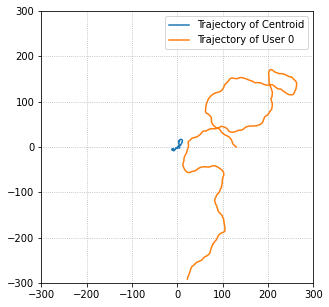

In [34]:
""" User movement: Gauss-Markov mobility model """

# Tracking positions of all users over time  
xaxis_all = np.zeros(shape=(n_users, n_slots))          # x-axis 
yaxis_all = np.zeros(shape=(n_users, n_slots))          # y-axis 

# Gen user movements using the Gauss-Markov model 
for id in range(n_users):
    x0 = rng.choice(initial_distance_range_x)
    y0 = rng.choice(initial_distance_range_y)
    
    xaxis_all[id], yaxis_all[id] = generate_mobility_GM(x0=x0, y0=y0, boundary=boundary, 
                                          n_slots=n_slots, slot_len=slot_len, 
                                          upper_left=upper_left, lower_right=lower_right)
        
# The centroid of all users over time 
x_centroid = np.mean(xaxis_all, axis=0)
y_centroid = np.mean(yaxis_all, axis=0)

# Plotting 
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(x_centroid, y_centroid, label='Trajectory of Centroid')
plt.plot(xaxis_all[0], yaxis_all[0], label='Trajectory of User 0')
ax.set(xlim=(-boundary, boundary), ylim=(-boundary,boundary), aspect='equal')  
plt.grid(True, linestyle=':')
plt.legend()
plt.show()


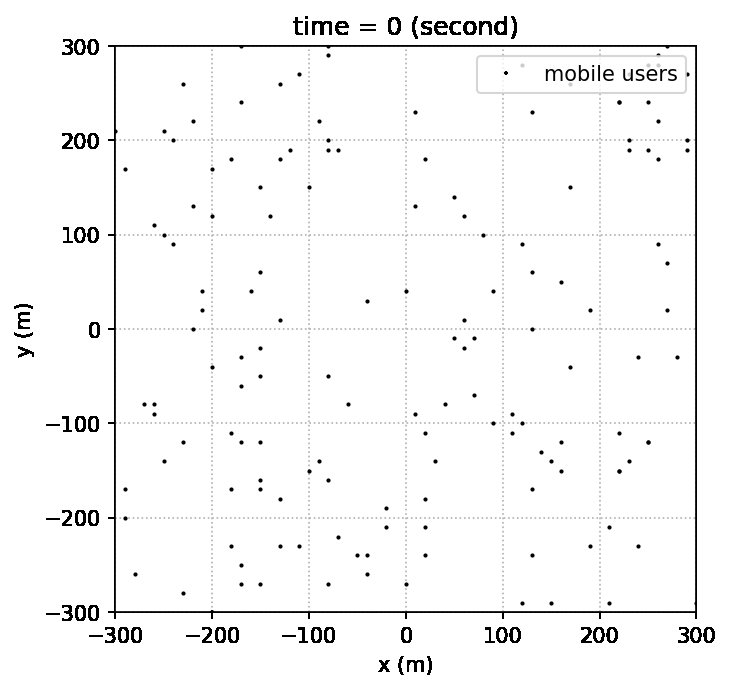

In [35]:
''' Animation of user locations '''
# Click [here](https://towardsdatascience.com/how-to-create-a-gif-from-matplotlib-plots-in-python-6bec6c0c952c) for a reference on Towards Data Science on how to create animations in Python.

def create_image_of_user_locations(xaxis_all=xaxis_all, yaxis_all=yaxis_all, t=0, folder_name='dev/png2gif', marker_sz=2):
    fig, ax = plt.subplots(figsize=(5,5))    # figsize in inch
    for id in range(n_users):
        plt.plot(xaxis_all[id][t], yaxis_all[id][t], linestyle='None', marker='.', color='k', markersize=marker_sz)
    plt.plot(xaxis_all[id][t], yaxis_all[id][t], linestyle='None', marker='+', color='k', markersize=marker_sz, label='mobile users')
    ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary))
    ax.set(title=f'time = {t} (second)', xlabel='x (m)', ylabel='y (m)')
    plt.legend(loc='upper right')       # options: 'best', 'upper left', 'upper right', 'lower left', 'lower right'
    plt.grid(True, linestyle=':')
    plt.savefig(os.path.join(os.getcwd(), folder_name, f"t{t}.png"), bbox_inches='tight', dpi=150)
    plt.close()

def gen_animation_user_locations(xaxis_all=xaxis_all, yaxis_all=yaxis_all, t_max=100, t_step=10, folder_name='dev/png2gif'):
    # plot user locations in each time slot as png images  
    for t in range(0,t_max,t_step): 
        create_image_of_user_locations(xaxis_all, yaxis_all, t, folder_name) 

    # save all image into a list 
    images = []
    for t in range(0,t_max,t_step): 
        image = imageio.v2.imread(os.path.join(os.getcwd(), folder_name, f"t{t}.png"))
        images.append(image)
            
    # combine all images into a GIF 
    path_to_gif = os.path.join(os.getcwd(), folder_name, 'user_location.gif')
    imageio.mimsave(path_to_gif, ims = images, fps = 1)  # ims = list of input images, [fps = frames per second]

    return path_to_gif

# display GIF 
gif_path = gen_animation_user_locations(t_max = 200, t_step = 10, folder_name = 'dev/png2gif')
Image(filename=gif_path, width=350)


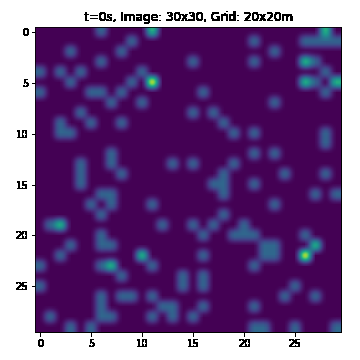

In [36]:
def gen_heatmap(x_locations, y_locations, val, norm_val):
    '''
    Generate a heatmap for the system statistic of interest 
    Parameters: 
        (x,y): the current location of each user, x.shape = y.shape = (n_users,)
        val: the network statistic of interest, shape=(n_users,)
        norm_val: the constant in support for normalizing the system statistic
    Returns: 
        heatmap: shape = (n_grids, n_grids)
    NOTE: the image's pixel should be as follows, (0,0)=top left corner
    (0,0) (0,1) (0,2)
    (1,0) (1,1) (1,2)
    (2,0) (2,1) (2.2) 
    '''
    global n_grids, grid_size, boundary 
    heatmap = 1e-6/norm_val*rng.uniform(size=(n_grids, n_grids))        # random noise 
    for user_id in range(x_locations.size):
        col_id = int(np.minimum(2*boundary-1,x_locations[user_id]+boundary)/grid_size)  # in range 0 -> (n_grids-1)
        row_id = int(np.minimum(2*boundary-1,boundary-y_locations[user_id])/grid_size)  # in range 0 -> (n_grids-1)
        heatmap[row_id, col_id] = heatmap[row_id, col_id] + val[user_id]/norm_val
    return heatmap 

def create_image_heatmap(xaxis_all, yaxis_all, t, val_all, norm_val): 
    heatmap = gen_heatmap(x_locations=xaxis_all[:,t], y_locations=yaxis_all[:,t], val=val_all, norm_val=norm_val)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(heatmap, interpolation='hamming') 
    ax.set(title=f't={t}s, Image: {n_grids}x{n_grids}, Grid: {grid_size}x{grid_size}m')
    plt.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), 'dev', 'heatmap', f"t{t}.png"))
    plt.close()
    
def gen_animation_heatmap(xaxis_all=xaxis_all, yaxis_all=yaxis_all, t_max=100, t_step=10):
    for t in range(0,t_max,t_step): 
        create_image_heatmap(xaxis_all, yaxis_all, t, val_all=np.ones(xaxis_all.shape[0]), norm_val=1) 
    images = []
    for t in range(0,t_max,t_step): 
        image = imageio.v2.imread(os.path.join(os.getcwd(), 'dev', 'heatmap', f"t{t}.png"))
        images.append(image)
    path_to_gif = os.path.join(os.getcwd(), 'dev', 'heatmap', 'heatmap.gif')
    imageio.mimsave(path_to_gif, ims = images, fps = 3)  # ims = list of input images, [fps = frames per second]

    return path_to_gif

# Plotting 
gif_path = gen_animation_heatmap(xaxis_all=xaxis_all, yaxis_all=yaxis_all, t_max = 50, t_step = 5)
Image(filename=gif_path, width=350)


### User Downlink Traffic (ON-OFF Model)
Reference on the Exponential Moving Average (EMA): [here]()

In [37]:
from copy import deepcopy

arrival_traffic_Mb = np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)
ema_traffic_Mb =  np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)        # EMA of the arrival rate (Mbps)
traffic_state = np.full(shape=(n_users, n_slots), fill_value=0, dtype=bool)
traffic_type = np.full(shape=(n_users,n_slots), fill_value=-1, dtype=int)

for uid in range(n_users): 
    traffic_state[uid,:], arrival_traffic_Mb[uid,:], traffic_type[uid,:] = \
        generate_traffic_ON_OFF(n_slots=n_slots, 
                                ON_duration_mean_tslot = ON_duration_mean_tslot,
                                OFF_duration_mean_tslot = OFF_duration_mean_tslot,
                                data_arrival_mean_Mb = ON_data_arrival_mean_Mb)

ema_traffic_Mb[:, 0] = alpha_ema*arrival_traffic_Mb[:,0]
for t in range(1,n_slots): 
    ema_traffic_Mb[:, t] = alpha_ema*arrival_traffic_Mb[:,t] + (1-alpha_ema)*ema_traffic_Mb[:,t-1]


print('Generated arrival traffic for all users\n')
print('Mean Traffic of one user (expected): \t{x:.2f} Mb/slot'.format(x=np.mean(ON_data_arrival_mean_Mb)*ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot)) )
print('Mean Traffic of one user (generated): \t{x:.2f} Mb/slot'.format(x=np.mean(arrival_traffic_Mb)) )
print('Arrival Rate in ON-state (generated): \t{x:.2f} Mb/slot'.format(x=np.sum(arrival_traffic_Mb)/np.sum(traffic_state)))


Generated arrival traffic for all users

Mean Traffic of one user (expected): 	0.60 Mb/slot
Mean Traffic of one user (generated): 	0.59 Mb/slot
Arrival Rate in ON-state (generated): 	1.19 Mb/slot


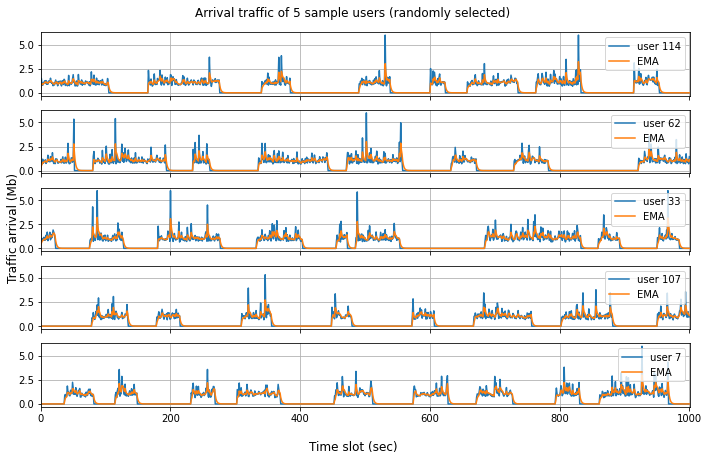

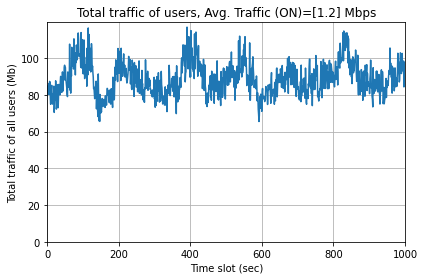

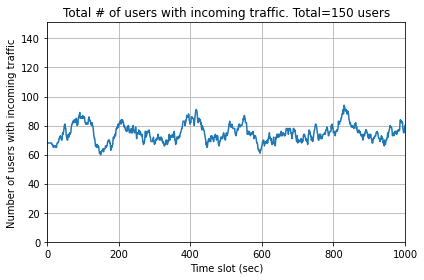

In [38]:
'''Plot arrival traffic of some sample users''' 
n_samples = 5 
sample_ids = np.random.choice(n_users, size=(n_samples), replace=False) # randomly select some users for plotting 
fig, axes = plt.subplots(n_samples,1, figsize=(10, 6.4), sharex=True, sharey=True)
for i, axis in enumerate(axes):
    axis.plot(arrival_traffic_Mb[sample_ids[i]], label=f'user {sample_ids[i]}')
    axis.plot(ema_traffic_Mb[sample_ids[i]], label='EMA')
    axis.grid(True)
    axis.legend(loc='upper right')
    axis.set(xlim=[0, n_slots])    
fig.suptitle(f"Arrival traffic of {n_samples} sample users (randomly selected)")
fig.supxlabel('Time slot (sec)')
fig.supylabel('Traffic arrival (Mb)')
fig.tight_layout()
plt.savefig("dev/incoming_traffic_of_sample_users_over_time.png", dpi=600, bbox_inches='tight')


"""Total incoming traffic of all users """
traffic_sum_Mb = np.sum(arrival_traffic_Mb, axis=0)
fig, ax = plt.subplots() 
plt.plot(traffic_sum_Mb)
plt.grid(True)
ax.set(xlabel='Time slot (sec)', ylabel='Total traffic of all users (Mb)', 
       title=f'Total traffic of users, Avg. Traffic (ON)={ON_data_arrival_mean_Mb} Mbps',
       xlim=[0, n_slots])
plt.ylim(bottom=0)
fig.tight_layout()
plt.show()


'''Number of users with incoming traffic''' 
traffic_state_sum = np.sum(traffic_state, axis=0)
fig, ax = plt.subplots() 
plt.plot(traffic_state_sum)
plt.grid(True)
ax.set(xlabel='Time slot (sec)', ylabel='Number of users with incoming traffic', 
       title=f'Total # of users with incoming traffic. Total={n_users} users',
       xlim=[0, n_slots], ylim=[0,n_users+1])
fig.tight_layout()
plt.show()


# System Evolvement
- The UAVs and users move round within the target zone 
- Channel condition fluctuation due to user movement
- Queue evolves based on arrival traffic and channel throughput


### Utility Functions
- Calcualte real-time __channel fadding gain__, given locations of the user and the UAV
- Calcualte __bandwidth allocation__ for each user (*) 
- Calculate real-time __channel capacity__ (maximum comm. rate) of each user 
- Find __active users__ in a time slot
- Calculate __effective throughput__ of each user 
- Update __queue length__ of each user 

(*) NOTE 2023/04/19: all users allocated fixed bandwidth, alpha = 1 for all users 

In [39]:
def cal_channel_fading_gain(x_user, y_user, x_uav, y_uav, uav_altitude): 
    '''Calculate the channel fading gain from locations of the user and the UAV'''
    radius_distance = np.sqrt(x_user**2 + y_user**2)    
    propagation_distance = np.sqrt((x_user-x_uav)**2 + (y_user-y_uav)**2 + uav_altitude**2)   
    elev_angle_deg = rad2deg(np.arctan(uav_altitude/radius_distance))
    channel_gain = channel_fading_gain_mean(elev_angle_deg) \
            * ref_receive_pw / propagation_distance**path_loss_exponent(elev_angle_deg)
    return channel_gain


def cal_channel_capacity_Mb(channel_gain, alpha): 
    ''' 
    Calculate the bandwidth (channel capacity, in Mbps) of one user in a time slot, given the channel gain and bandwidth allocation (alpha, in range (0,1)) 
    NOTE 2023/04/19: bandwidth of one users are fixed, alpha should be equal to 1 for all users 
    '''
    assert alpha == 1, "Update on 2023/04/19: alpha shoule equal to 1 for all users"
    SNR = pTx_downlink * channel_gain / noise_pw_total
    capacity_Mb = to_Mbit(alpha * bw_1user * np.log2(1 + SNR) * slot_len )
    return capacity_Mb 


def find_active_users(queue_len_Mb=0, incoming_traffic_Mb=0): 
    ''' 
    Find active users (queue length > 0 or incoming traffic > 0)
    Parameters: 
        - queue_len_Mb (shape=(n_users,)): current queue length in Mb
        - incoming_traffic_Mb (shape=(n_users,)): incoming traffic in Mb 
    Returns:
        - active_state (shape=(n_users,)): binary (False if inactive and True if active) 
    '''
    traffic_total_Mb  = queue_len_Mb + incoming_traffic_Mb      # shape = (n_users,)
    active_state =  np.array(traffic_total_Mb > 0)              # shape = (n_users,)
    return active_state


def cal_bandwidth_equal(active_state):
    '''
    Equal bandwidth allocation for each active user. 
    Example: 5 out of 10 users are active -> allocate 1/5 of the total bandwidth to each
    Parameters:  
        - active_state: shape = (n_users,), =1 if queue + traffic_arrival > 0
    Returns: 
        - alpha: bandwidth allocation, in range (0,1), shape=(n_users,)
    NOTE 2023/04/19: alpha = 1 for all users, since users are allocated fixed bandwidth during the process  
    '''
    # alpha = np.ones(shape=(n_users)) * 1/n_users              # shape = (n_users,), equally shared between all users  
    # alpha = active_state*1/np.sum(active_state) + 1e-6        # shape = (n_users,), equally shared between active users 
    alpha = np.ones(shape=(n_users))
    return alpha 


def update_queue_Mb(qlen_prev_Mb, arrival_Mb, departure_Mb):
    '''Return the updated qlen based on the previous qlen, arrival traffic, and departure rate'''
    qlen_next_Mb = np.max([qlen_prev_Mb + arrival_Mb - departure_Mb, 0])
    return qlen_next_Mb


def cal_downlink_throughput_Mb(qlen_prev_Mb, arrival_Mb, channel_capacity_Mb):
    '''Calculate the user's download speed (Mbps). If qlen+traffic=0, then throughput=0'''
    throughput_Mb = np.min([channel_capacity_Mb, qlen_prev_Mb + arrival_Mb])
    return throughput_Mb


def load_user_properties(users_list, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb):
    '''Load the movements and arrival traffic to each user object'''
    for uid, user in enumerate(users_list): 
        user.x = deepcopy(xaxis_all[uid,:])
        user.y = deepcopy(yaxis_all[uid,:])
        user.arrival_traffic_Mb = deepcopy(arrival_traffic_Mb[uid,:])
        user.traffic_state = deepcopy(traffic_state[uid,:])
        user.traffic_type = deepcopy(traffic_type[uid,:])
        user.ema_drate_Mbps = deepcopy(ema_traffic_Mb[uid,:])



### QoE Score (MOS) Function 
 

In [40]:
def mos_func(qlen, lambda_): 
    ''' Estimate the Mean Opinion Score (MOS) of users 
        Parameters: 
            - qlen: the current queue length, scalar or array-like 
            - lambda_: the expected arrival rate, scalar or array-like
        Return: 
            - mos_val: scalar or array-like 
        Reference: ITU-T G.1030 (02/2014), eq. (II-2) and Fig. II.4, page 17
    '''
    a, b = 5.72, 0.936
    mos_val_min, mos_val_max = 1.0, 5.0 
    mos_val = a - b*np.log(qlen/lambda_ + 1e-6)
    mos_val = np.minimum(mos_val, mos_val_max)      
    mos_val = np.maximum(mos_val, mos_val_min)
    return mos_val 

   qlen_Mb  arrival_rate_Mbps       mos
0        0                1.0  5.000000
1        1                1.0  5.000000
2        2                1.0  5.000000
3        3                1.0  4.691699
4        4                1.0  4.422428


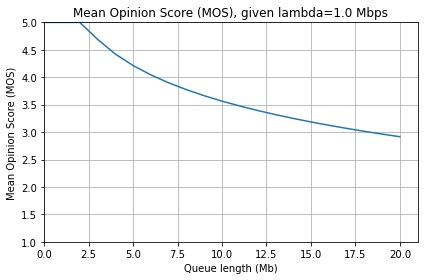

In [41]:
'''Visualize the MOS function'''
qlen = np.arange(0, 21, step=1)                # Mb 
lambda_ = np.ones(shape=(len(qlen)))            # Mbps 

mos = mos_func(qlen=qlen, lambda_=lambda_)
df_mos = pd.DataFrame({'qlen_Mb': qlen, 'arrival_rate_Mbps': lambda_, 'mos': mos})
print(df_mos.head())

sns.lineplot(data=df_mos, x='qlen_Mb', y='mos')
plt.grid(True)
plt.xlim(left=0)
plt.ylim([1,5])
plt.xlabel('Queue length (Mb)')
plt.ylabel('Mean Opinion Score (MOS)')
plt.title(f'Mean Opinion Score (MOS), given lambda={lambda_[0]} Mbps')
plt.tight_layout()
plt.show()

### User Clustering Algorithm

In [42]:
from sklearn.cluster import KMeans

def kmeans_clustering(loc_users, loc_uavs):
    '''Cluster users in to groups using KMeans Clustering, each corresponding to a UAV
    Params: 
        - loc_users: positions of all users, shape=(n_users, 3)
        - loc_uavs: positions of UAVs, shape=(n_uavs, 3) 
    Return: 
        - cluster_mat : shape=(n_users, n_uavs), cluster_mat[i,j] = 1 -> user i is associated to uav j 
    
    Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    '''
    n_clusters = loc_uavs.shape[0]                          # no. of clusters = no. of UAVs
    kmeans = KMeans(n_clusters=n_clusters, init=loc_uavs,   # initial locations for clustering
                    n_init=1, verbose=0).fit(loc_users)     # standard X.shape = (n_samples, n_features)
    cluster_mat = np.eye(n_clusters)[kmeans.labels_] 
    
    return cluster_mat, kmeans.labels_, kmeans.cluster_centers_


In [43]:
'''Utility functions for plotting with clusters'''
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib 
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

def gen_image_with_clusters(xaxis_all, yaxis_all, uavswarm, t, folder_name, marker_sz, color_codes, markers):
    fig, ax = plt.subplots(figsize=(5,5))    # figsize in inch
    for id in range(n_users): 
        plt.plot(xaxis_all[id][t], yaxis_all[id][t], linestyle='None', marker=markers[id], 
                 markeredgecolor=color_codes[id], markerfacecolor='None', markersize=marker_sz) # markeredgewidth
    for id, uav in enumerate(uavswarm):
        plt.plot(uav.x[t], uav.y[t], linestyle='None', marker='x', label=uav.name,
                 markeredgecolor=colors[id], markerfacecolor='None', markersize=7, markeredgewidth=2)
    ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary))
    ax.set(title=f'time = {t} (second)', xlabel='x (m)', ylabel='y (m)')
    plt.legend(bbox_to_anchor=(1.02, 0.3), loc='lower left')       # options: 'best', 'upper left', 'upper right', 'lower left', 'lower right'
    plt.grid(True, linestyle=':')
    plt.savefig(os.path.join(os.getcwd(), folder_name, f"t{t}.png"), bbox_inches='tight', dpi=600)
    plt.close()

def gen_image_with_clusters_3D(xaxis_all, yaxis_all, uavswarm, t, folder_name, marker_sz, color_codes, markers, alphas):
    fig = plt.figure(figsize=(6,6))    # figsize in inch
    ax  = fig.add_subplot(111, projection='3d')
    for id in range(n_users): 
        s_ = 1.5*marker_sz if markers[id] == '^' else marker_sz
        ax.scatter(xaxis_all[id][t], yaxis_all[id][t], linestyle='None', marker=markers[id], 
                    edgecolors=color_codes[id], color='none', s=s_, alpha=alphas[id]) # linewidths
    
    for id, uav in enumerate(uavswarm):
        s_ = 3*marker_sz if markers_cluster[id] == '^' else 2*marker_sz
        zvec = uav.z[t]*np.arange(0,0.99,0.98); xvec = uav.x[t]*np.ones(2); yvec = uav.y[t]*np.ones(2); 
        ax.scatter(uav.x[t], uav.y[t], uav.z[t], linestyle='None', marker=markers_cluster[id], label=uav.name,
                    edgecolors=colors[id], color='none', s=s_, linewidths=1)
        ax.scatter(uav.x[t], uav.y[t], uav.z[t], marker='1', s=20, linewidths=1) # edgecolors=colors[id]
        ax.text(uav.x[t]+5, uav.y[t]+5, uav.z[t]+5, uav.name[:5] + f' ({uav.z[t]:.0f}m)')
        ax.plot(xvec,yvec,zvec,linestyle='--', linewidth=1, dashes=(5,5), alpha=0.7)  # dashes=(length,interval_length)
    
    ax.view_init(elev=20, azim=120)    
    ax.set_box_aspect([1,1,0.6])        # ax.set_aspect('auto') 
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.zaxis.set_major_locator(ticker.LinearLocator(4))
    ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary), zlim=(0,z_max))  
    ax.set(title=f'time = {t} (second)', xlabel='x (m)', ylabel='y (m)', zlabel='z (m)')
    # ax.legend(loc='best', ncol=2)       # options: 'best', 'upper left', 'upper right', 'lower left', 'lower right', bbox_to_anchor=(1.02, 0.2)
    # ax.grid(visible=True, linestyle='--') # not working on 3d plots 
    fig.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), folder_name, f"t{t}.png"), bbox_inches='tight', dpi=150)
    plt.close()
    

def gen_animation_with_clusters(users, uavswarm, xaxis_all=xaxis_all, yaxis_all=yaxis_all, dim = '2d',
                                t_max=100, t_step=10, folder_name='dev/png2gif', gifname='animation', fps=3):
    # plot user locations in each time slot as png images  
    for t in range(0,t_max,t_step): 
        color_codes = [colors[int(user.cluster[t])] for user in users]      
        marker_codes = [markers_cluster[int(user.cluster[t])] for user in users] 
        alphas = [1 if user.active_state[t] == True else 0.6 for user in users]
        if dim == '2d':  
            gen_image_with_clusters(xaxis_all, yaxis_all, uavswarm, t, folder_name, marker_sz=5, color_codes=color_codes, markers=marker_codes) 
        elif dim == '3d':
            gen_image_with_clusters_3D(xaxis_all, yaxis_all, uavswarm, t, folder_name, marker_sz=20, color_codes=color_codes, markers=marker_codes, alphas=alphas) 
    
    # save all image into a list 
    images = []
    for t in range(0,t_max,t_step): 
        image = imageio.v2.imread(os.path.join(os.getcwd(), folder_name, f"t{t}.png"))
        images.append(image)
            
    # combine all images into a GIF 
    path_to_gif = os.path.join(os.getcwd(), folder_name, gifname)
    imageio.mimsave(path_to_gif, ims = images, fps = fps)  # ims = list of input images, [fps = frames per second]

    return path_to_gif

### UAV Swarm (Stationary)

In [44]:
# Initiate the UAV Swarm 
uavswarm_stationary = [UAV(name= f'UAV {i} (Stationary)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
                xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=0, speedz_max=0) for i in range(0,n_uavs)]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_stationary = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_stationary, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb)

# Alias for ease of code maintenance 
uavs = uavswarm_stationary
users = users_stationary          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)    # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0
    
    # (1) User Clustering 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1),
                           np.expand_dims(yaxis_all[:,t], axis=1),
                           np.zeros(shape=(n_users,1))))                    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # (2) UAV Updates: Movement and Energy Consumption  
    for uav in uavs: 
        uav.x[t], uav.y[t], uav.z[t] = uav.x[0], uav.y[0], uav.z[0] 
    
    # (3) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = 1       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.ema_drate_Mbps[t]) if (isActive_all[id]==True) else np.nan 


In [45]:
### For testing user clustering algo 
t = 0
loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1),
                        np.expand_dims(yaxis_all[:,t], axis=1),
                        np.zeros(shape=(n_users,1))))   
loc_uavs = np.array([[uav.x[t], uav.y[t], uav.z[t]] for uav in uavswarm_stationary])   # shape = (n_uavs, 3)
cluster_mat, labels, cluster_centers = kmeans_clustering(loc_users, loc_uavs)
print(labels)
print(cluster_mat[:5,:])
# print(cluster_centers)
print(xaxis_all[labels==0,t].shape)
# print(np.mean(xaxis_all[cluster_mat[:,0].astype(int),t]))

[2 1 3 0 2 1 0 3 1 1 0 0 1 2 2 0 3 3 2 1 2 2 1 1 2 0 0 1 3 0 0 2 3 2 1 3 0
 0 2 1 1 1 3 1 1 3 2 2 2 3 1 0 1 0 1 2 3 2 2 2 2 3 1 3 1 0 3 2 0 1 2 1 0 0
 2 1 2 0 1 0 2 1 3 1 3 3 2 3 3 1 1 2 0 1 1 0 0 3 3 2 0 2 1 2 1 2 2 1 0 2 0
 1 0 0 0 1 2 0 1 2 3 2 3 1 0 0 0 3 3 0 0 3 3 0 3 2 0 0 3 0 2 1 3 2 3 2 1 1
 0 1]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
(39,)


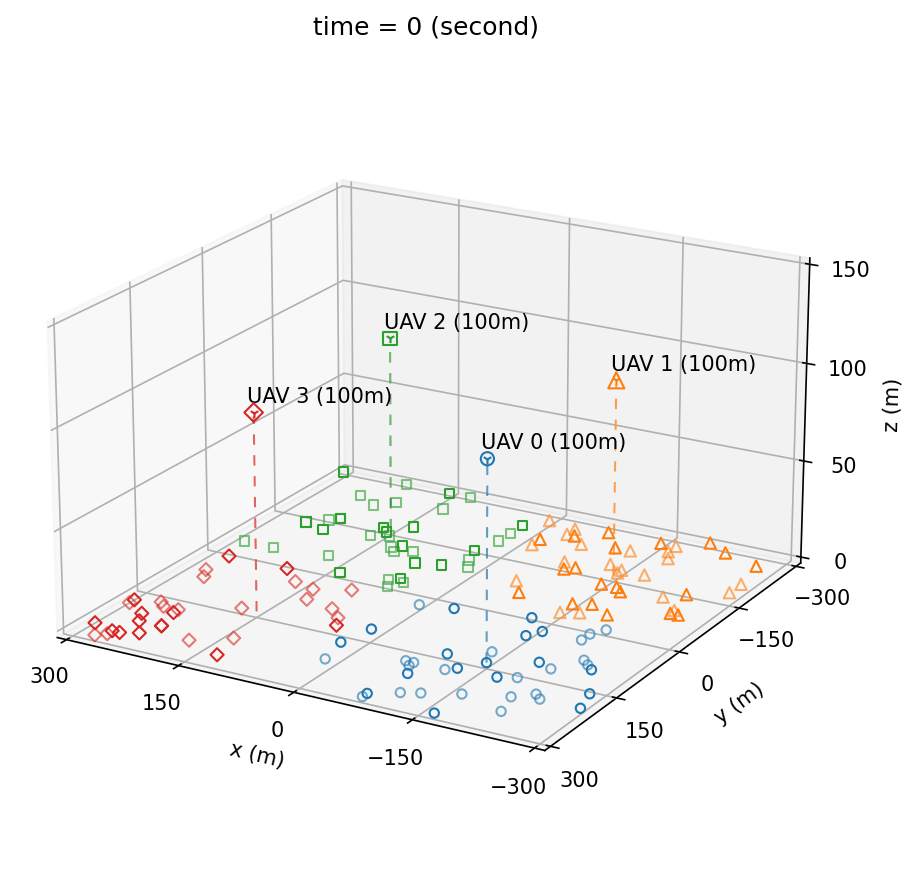

In [46]:
### Animation of locations of UAVs and users
gif_path = gen_animation_with_clusters(users=users_stationary, uavswarm=uavswarm_stationary, dim='3d', t_max = 10, t_step = 10, 
                                       folder_name = 'dev/png2gif/stationary', gifname='swarm_stationary.gif', fps=2)
Image(filename=gif_path, width=500)

### UAV Swarm (Centroid)

In [47]:
# Initiate the UAV Swarm 
uav_swarm_centroid = [UAV(name= f'UAV {i} (Centroid)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
                        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_centroid = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_centroid, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb)

# Alias for ease of code maintenance 
uavs = uav_swarm_centroid
users = users_centroid          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0
    
    # (1) User Clustering 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # (2) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            xc, yc = np.mean(xaxis_all[cids==cid,t]), np.mean(yaxis_all[cids==cid,t])   # centroid of the cluster 
            dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], xc, yc)
            uav_speed = np.min([dd/(uav.speedxy_max*slot_len), 1])*uav.speedxy_max
            uav.x[t], uav.y[t] = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
            uav.z[t] = uav.z[0] 
    
    # (3) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = 1       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.ema_drate_Mbps[t]) if (isActive_all[id]==True) else np.nan 


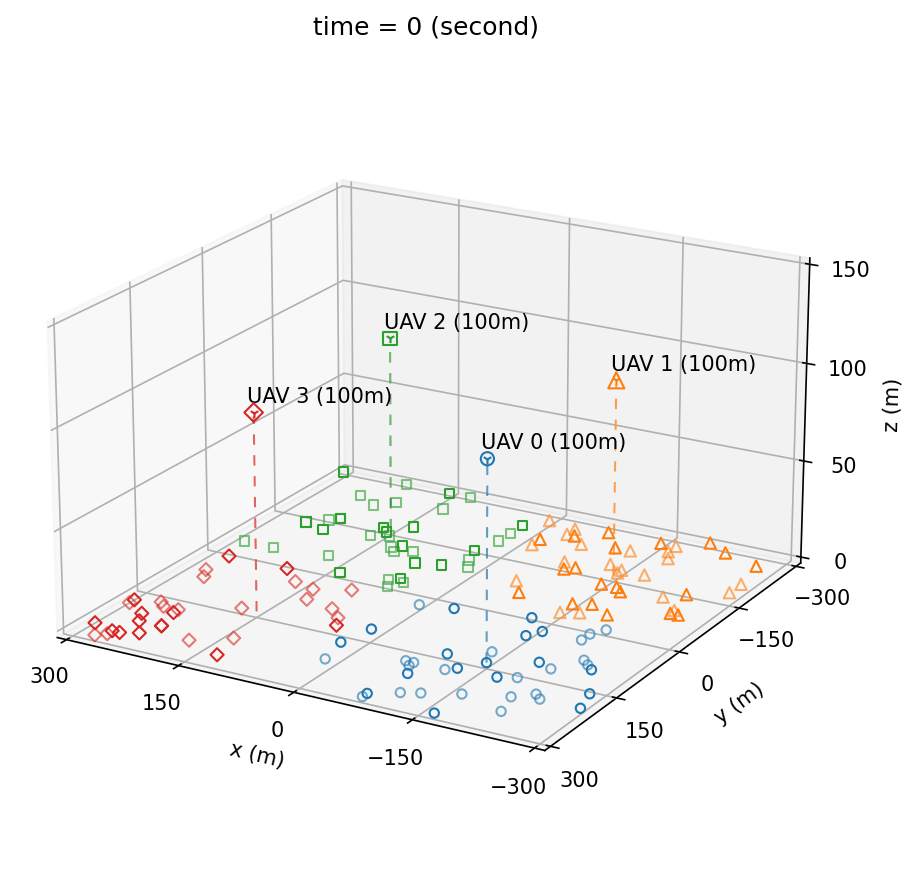

In [48]:
### Animation of locations of UAVs and users
gif_path = gen_animation_with_clusters(users=users_stationary, uavswarm=uav_swarm_centroid, dim='3d', t_max = 200, t_step = 10, 
                                       folder_name = 'dev/png2gif/centroid', gifname='swarm_centroid.gif', fps=2)
Image(filename=gif_path, width=500)

### UAV Swarm (Centroid-Active)
NOTE: 2D placement, the horizontal position of UAVs are unchanged

In [49]:
# Initiate the UAV Swarm 
uav_swarm_centroid_active = [UAV(name= f'UAV {i} (Centroid-Active)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
                        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_centroid_active = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_centroid_active, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb)

# Alias for ease of code maintenance 
uavs = uav_swarm_centroid_active
users = users_centroid_active          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), True if qlen + traffic > 0
        
    # (1) User Clustering: based on locations of users 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # (2) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            mask = (cids==cid) & isActive_all   # True if an user belongs to the cluster and is active  
            if np.any(mask==True):      # If some users in the cluster are active   
                xc, yc = np.mean(xaxis_all[mask,t]), np.mean(yaxis_all[mask,t])   # centroid of the cluster    
                dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], xc, yc)
                uav_speed = np.min([dd/(uav.speedxy_max*slot_len), 1])*uav.speedxy_max
                uav.x[t], uav.y[t] = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
                uav.z[t] = uav.z[0] 
            else:       # If no users is active, then the UAV makes no movement 
                uav.x[t], uav.y[t], uav.z[t] = uav.x[t-1], uav.y[t-1], uav.z[0]
    
    # (3) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = 1       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.ema_drate_Mbps[t]) if (isActive_all[id]==True) else np.nan 


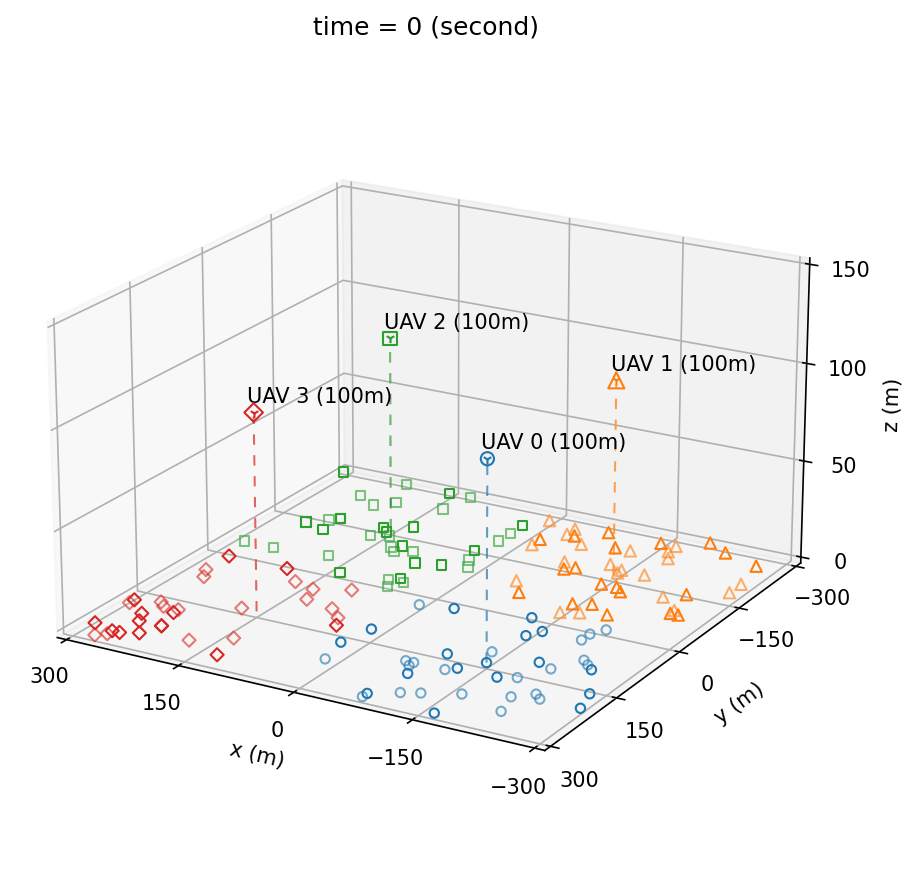

In [50]:
### Animation of locations of UAVs and users
gif_path = gen_animation_with_clusters(users=users_centroid_active, uavswarm=uav_swarm_centroid_active, dim='3d', t_max = 100, t_step = 10, 
                                       folder_name = 'dev/png2gif/centroid-active', gifname='swarm_centroid_active.gif', fps=2)
Image(filename=gif_path, width=500)

### UAV Swarm (Proposed)

In [51]:
# Initiate the UAV Swarm 
uav_swarm_proposed = [UAV(name= f'UAV {i} (Proposed)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init_proposed, 
                        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# UAV's flight controller 
uav_controller = UAV_Movement_Controller(boundary=boundary, grid_size=grid_size, uav_speedxy_max=uav_speedxy_max, n_decisions=n_decisions, 
                                         n_uavs=n_uavs, zmin=z_min, zmax=z_max, uav_speedz_max=uav_speedz_max)  
uav_controller.cal_channel_fading_gain = cal_channel_fading_gain 
uav_controller.cal_channel_capacity_Mb = cal_channel_capacity_Mb
uav_controller.gen_heatmap = gen_heatmap                
uav_controller.Vlya = lyapunov_param

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_proposed = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_proposed, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb)

# Alias for ease of code maintenance 
uavs = uav_swarm_proposed
users = users_proposed          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    capacity_Mb = np.array([user.channel_capacity_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), True if qlen + traffic > 0
    
    # (1) User Clustering: based on locations of users 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # (2) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            uav_location = (uav.x[t-1], uav.y[t-1], uav.z[t-1])  
            user_locations = (xaxis_all[:,t], yaxis_all[:,t])    # a tupple of 2 arrays of shape (n_users,)
            mask = (cids==cid) & isActive_all       # True if an user belongs to the cluster and is active (i.e., qlen + traffic > 0)
            
            # (2.0) Collect user statistics
            # Only users belonging to the considered cluster are counted  
            # Random noise-added to avoid gradient vanishing problem
            queue_Mb_masked =  1e-6*np.random.rand(n_users) + queue_length_Mb*mask  # shape = (n_users,)
            traffic_Mb_masked = 1e-6*np.random.rand(n_users) + traffic_Mb*mask      # shape = (n_users,) 
            capacity_Mb_masked = 1e-6*np.random.rand(n_users) + capacity_Mb*mask    # shape = (n_users,)
            user_statistics = (queue_Mb_masked, traffic_Mb_masked, capacity_Mb_masked)  # shape = (n_users,3)
            
            # (2.1) Make a movement decision (dx, dy, and uav_speed)
            # (2.2) Update the replay memory
            dnn_prediction, best_decision = uav_controller.make_movement_decision(uav_location=uav_location, user_locations=user_locations, user_statistics=user_statistics, normalization_coeff=normalization_coeff)
            dx, dy, vxy, dz, vz = best_decision       # dx and dy: -1 to 1, uav_speedxy: 0 to uav_speed_max, uav_speedz: -1 to 1 
            
            # (2.3) Retrain the DNN periodically 
            if (uav_controller.memory_counter_train >= uav_controller.min_samples_for_training) and (uav_controller.memory_counter_train % uav_controller.training_interval == 0):
                uav_controller.retrain_dnn()
            
            # (2.4) Update the UAV location 
            xt, yt = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=vxy, slot_len=slot_len)
            uav.x[t] = adjust_location(xt, bound=boundary)
            uav.y[t] = adjust_location(yt, bound=boundary)
            zt = update_UAV_altitude(z0=uav.z[t-1], dz=dz, vz=vz, slot_len=slot_len)
            uav.z[t] = adjust_altitude(zt, zmin=z_min, zmax=z_max)
    
    # (3) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = 1       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.ema_drate_Mbps[t]) if (isActive_all[id]==True) else np.nan 


3/3 - 2s - loss: 0.1589 - mae: 0.3217 - val_loss: 0.1437 - val_mae: 0.3056
3/3 - 0s - loss: 0.1476 - mae: 0.3123 - val_loss: 0.1427 - val_mae: 0.3097
3/3 - 0s - loss: 0.1439 - mae: 0.3077 - val_loss: 0.1404 - val_mae: 0.3062
4/4 - 1s - loss: 0.1432 - mae: 0.3069 - val_loss: 0.1520 - val_mae: 0.3206
4/4 - 0s - loss: 0.1393 - mae: 0.3017 - val_loss: 0.1537 - val_mae: 0.3206
4/4 - 0s - loss: 0.1324 - mae: 0.2927 - val_loss: 0.1459 - val_mae: 0.3079
4/4 - 0s - loss: 0.1274 - mae: 0.2863 - val_loss: 0.1418 - val_mae: 0.3035
4/4 - 0s - loss: 0.1247 - mae: 0.2834 - val_loss: 0.1393 - val_mae: 0.3004
4/4 - 0s - loss: 0.1201 - mae: 0.2789 - val_loss: 0.1380 - val_mae: 0.3049
4/4 - 0s - loss: 0.1226 - mae: 0.2807 - val_loss: 0.1334 - val_mae: 0.2989
4/4 - 0s - loss: 0.1207 - mae: 0.2809 - val_loss: 0.1354 - val_mae: 0.3026
4/4 - 0s - loss: 0.1175 - mae: 0.2760 - val_loss: 0.1365 - val_mae: 0.3042
5/5 - 0s - loss: 0.1179 - mae: 0.2745 - val_loss: 0.1355 - val_mae: 0.3008
5/5 - 0s - loss: 0.1183 -

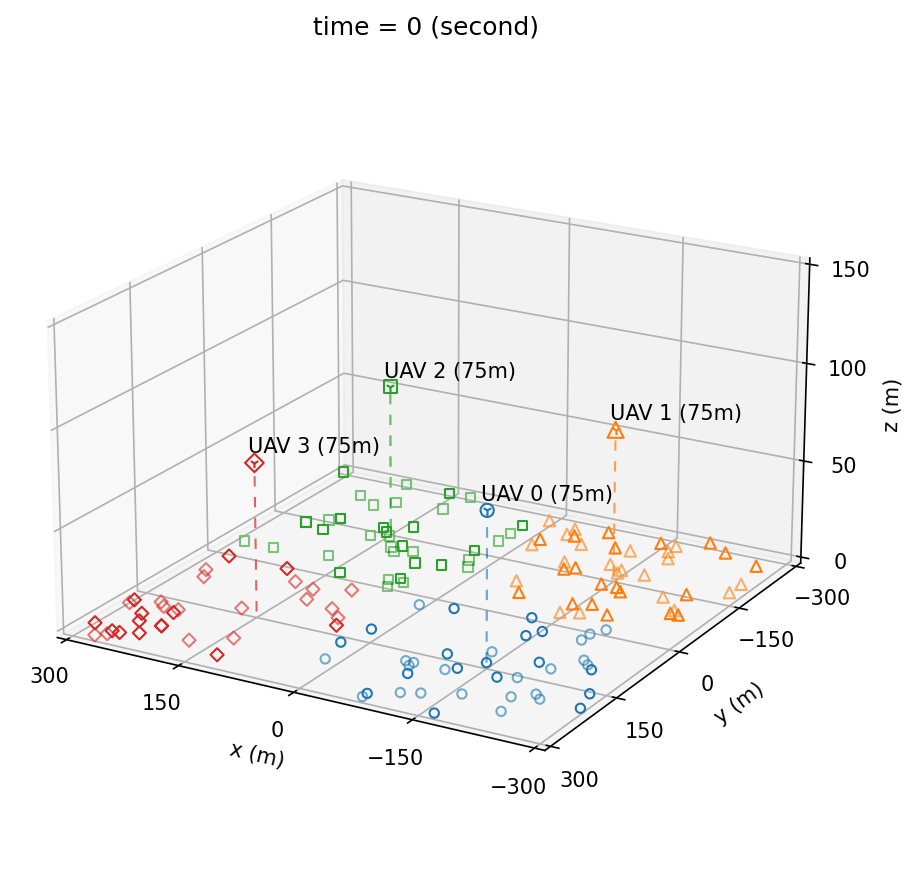

In [52]:
### Animation of locations of UAVs and users
gif_path = gen_animation_with_clusters(users=users_proposed, uavswarm=uav_swarm_proposed, dim='3d', t_max = 300, t_step = 10, 
                                       folder_name = 'dev/png2gif/proposed', gifname='swarm_proposed.gif', fps=2)
Image(filename=gif_path, width=500)

##### UAV Altitude

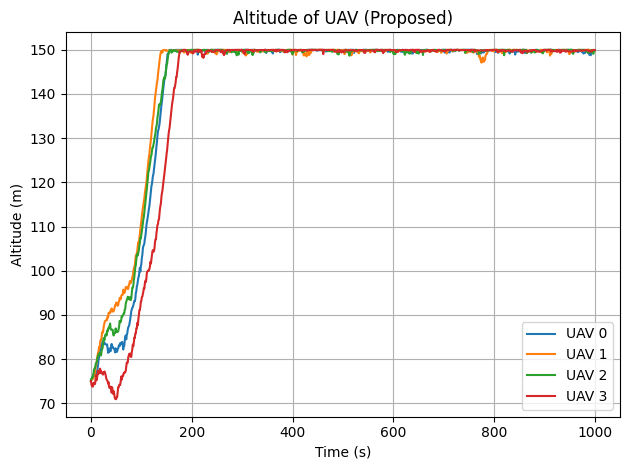

In [53]:
'''Plot the UAV altitude'''

fig, ax = plt.subplots()
for uav in uav_swarm_proposed:
    plt.plot(uav.z, label=f'{uav.name[:5]}')
ax.set(xlabel="Time (s)", ylabel="Altitude (m)", title="Altitude of UAV (Proposed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig('dev/uav_altitude_proposed.png', dpi=300)


##### Training history

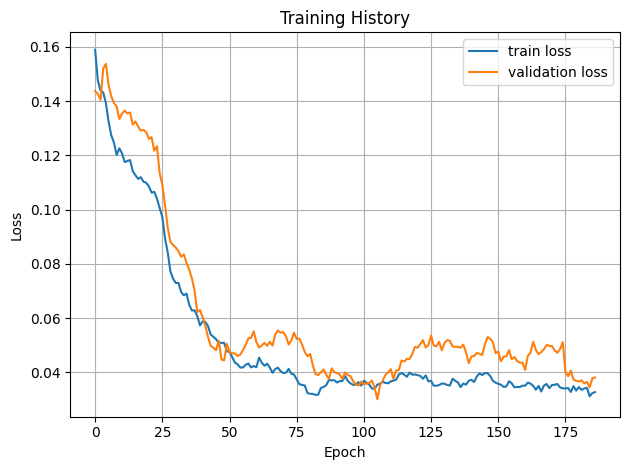

In [54]:
'''Plot training history'''

train_loss_hist = uav_controller.train_loss_history     # export_moving_average(uav_controller.train_loss_history, rolling_intv=100)
val_loss_hist = uav_controller.val_loss_history
# time_axis = uav_controller.min_samples_for_training/n_uavs + np.arange(stop=len(train_loss_hist))*uav_controller.training_interval/n_uavs

fig, ax = plt.subplots()
plt.plot(train_loss_hist, label='train loss')
plt.plot( val_loss_hist, label='validation loss')
ax.set(xlabel='Epoch', ylabel='Loss', title='Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('dev/train_history', dpi=300, bbox_inches='tight')
# plt.show()


# Statistics of System's Performance


In [55]:
users_list = [users_stationary, users_centroid, users_centroid_active, users_proposed]
uavs_list = [uavswarm_stationary, uav_swarm_centroid, uav_swarm_centroid_active, uav_swarm_proposed]
names = ['Stationary', 'Centroid', 'Centroid (Active)', 'Proposed']
xlim_tmax = 501


##### Queue Length

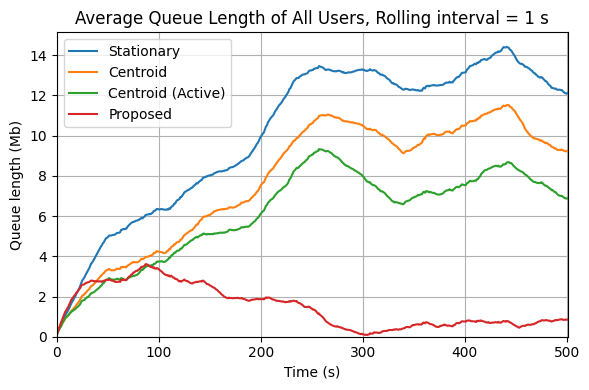

In [56]:
rolling_interval = 1

fig, ax = plt.subplots(figsize=(6,4))
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([user.queue_length_Mb for user in users])
    state_all = np.array([user.active_state for user in users])
    # qlen_avg = np.sum(qlen_all, axis=0)/np.sum(state_all, axis=0)
    kpi_avg = np.sum(kpi_all, axis=0)/n_users
    kpi_mmean = export_moving_average(kpi_avg, rolling_intv=rolling_interval)          # Average Queue Length 
    plt.plot(kpi_mmean, label=fname)
ax.set(xlabel='Time (s)', ylabel='Queue length (Mb)', title=f'Average Queue Length of All Users, Rolling interval = {rolling_interval} s')    
plt.grid(True)
plt.legend()
plt.xlim([0,xlim_tmax])
plt.ylim(bottom=0)
fig.tight_layout()
plt.show()


Figure: Moving Average, Min and Max of Queue Length of Active Users
Rolling interval = 50 s


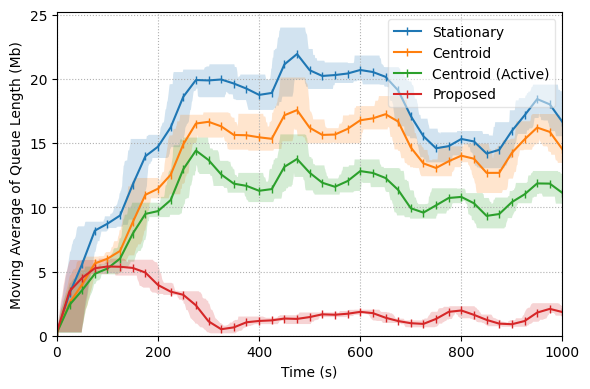

In [57]:
rolling_interval = 50
tvec = np.arange(0,n_slots)
xlim_tmax = 1000
t_step = 25             # for the moving average of KPI 

print(f'Figure: Moving Average, Min and Max of Queue Length of Active Users')
print(f'Rolling interval = {rolling_interval} s')

fig, ax = plt.subplots(figsize=(6,4))
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([user.queue_length_Mb for user in users])
    state_all = np.array([user.active_state for user in users])
    kpi_avg = np.sum(kpi_all, axis=0)/np.sum(state_all, axis=0)
    kpi_mmean = export_moving_average(kpi_avg, rolling_intv=rolling_interval)          # Average Queue Length 
    kpi_mmin = export_moving_min(kpi_avg,rolling_interval)
    kpi_mmax = export_moving_max(kpi_avg,rolling_interval)
    plt.plot(tvec[::t_step], kpi_mmean[::t_step], '-|', markerfacecolor='None', label=fname)
    ax.fill_between(x=tvec, y1=kpi_mmin, y2=kpi_mmax, alpha=0.2)
ax.set(xlabel='Time (s)', ylabel='Moving Average of Queue Length (Mb)')    
plt.grid(True, linestyle=':')
plt.legend(fancybox=True, framealpha=0.5)   
plt.xlim([0,xlim_tmax])
plt.ylim(bottom=0)
fig.tight_layout()

plt.savefig(f'dev/Moving_Average_QueueLength_Rolling_{rolling_interval}s.png', dpi=600, bbox_inches='tight')


### Effective Throughput 

Figure: Moving Average, Min and Max of Downlink Throughput of Active Users
Rolling interval = 50 s


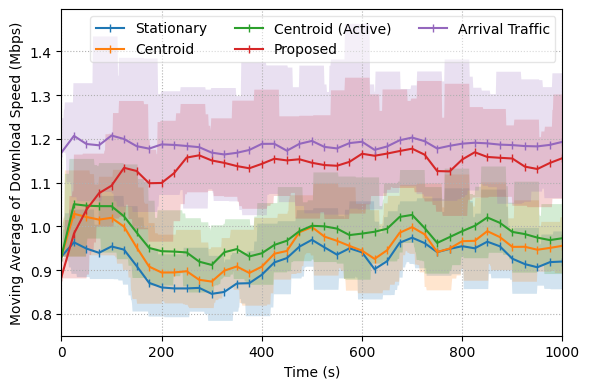

In [58]:
rolling_interval = 50
tvec = np.arange(0,n_slots)
xlim_tmax = 1000
t_step = 25             # for the moving average of KPI 

print(f'Figure: Moving Average, Min and Max of Downlink Throughput of Active Users')
print(f'Rolling interval = {rolling_interval} s')

fig, ax = plt.subplots(figsize=(6,4))
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([user.downlink_throughput_Mb for user in users])
    state_all = np.array([user.active_state for user in users])
    kpi_avg = np.sum(kpi_all, axis=0)/np.sum(state_all, axis=0)
    kpi_mmean = export_moving_average(kpi_avg, rolling_interval)          # Average Queue Length 
    kpi_mmin = export_moving_min(kpi_avg,rolling_interval)
    kpi_mmax = export_moving_max(kpi_avg,rolling_interval)
    plt.plot(tvec[::t_step], kpi_mmean[::t_step], '-|', markerfacecolor='None', label=fname)
    ax.fill_between(x=tvec, y1=kpi_mmin, y2=kpi_mmax, alpha=0.2)
traffic_active = traffic_sum_Mb/traffic_state_sum
traffic_mmean = export_moving_average(traffic_active, rolling_interval)
traffic_mmin = export_moving_min(traffic_active, rolling_interval)
traffic_mmax = export_moving_max(traffic_active, rolling_interval)
plt.plot(tvec[::t_step], traffic_mmean[::t_step], '-|', markerfacecolor='None', label='Arrival Traffic')
ax.fill_between(x=tvec, y1=traffic_mmin, y2=traffic_mmax, alpha=0.2)
ax.set(xlabel='Time (s)', ylabel='Moving Average of Download Speed (Mbps)')    
plt.grid(True, linestyle=':')
plt.legend(fancybox=True, framealpha=0.5, ncol=3)
plt.xlim([0,xlim_tmax])
# plt.ylim(bottom=0)
fig.tight_layout()

plt.savefig(f'dev/Moving_Average_Throughut_Rolling_{rolling_interval}s.png', dpi=600, bbox_inches='tight')


### User Heatmap

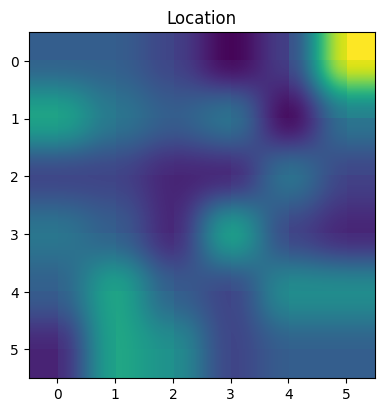

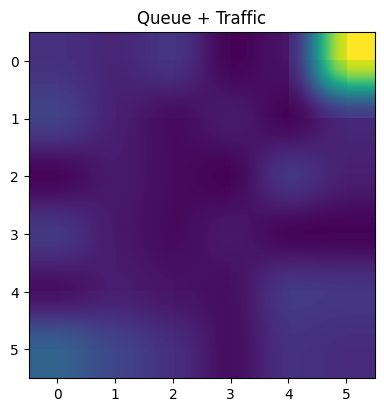

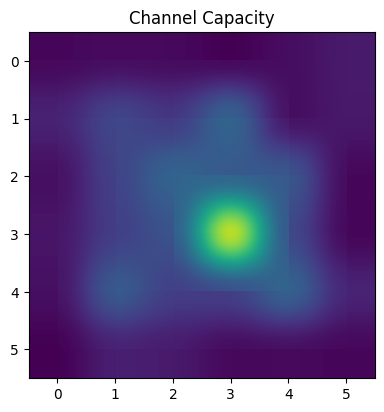

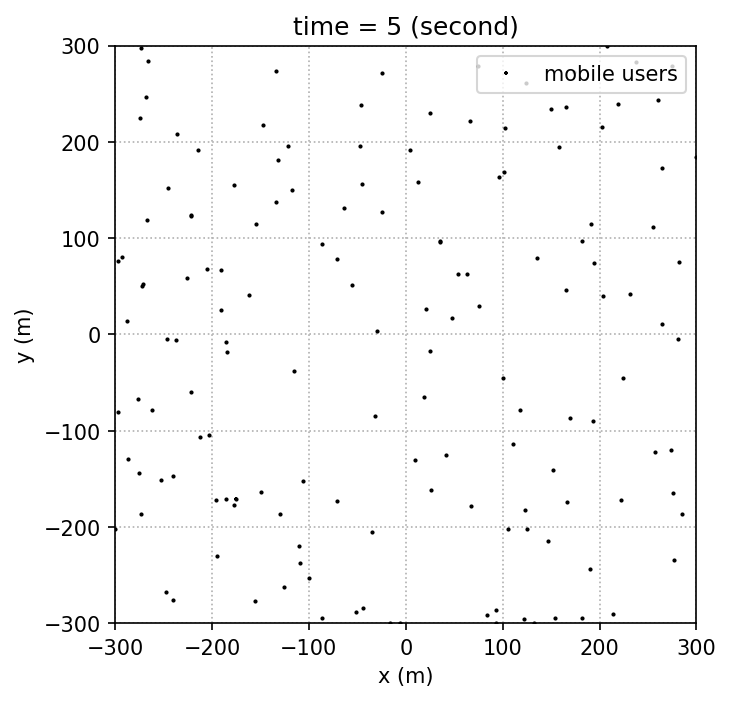

In [59]:
def gen_heatmap2(x_locations, y_locations, val, norm_val, n_grids, grid_size):
    '''
    Generate a heatmap for the system statistic of interest 
    Parameters: 
        (x,y): the current location of each user, x.shape = y.shape = (n_users,)
        val: the network statistic of interest, shape=(n_users,)
        norm_val: the constant in support for normalizing the system statistic
    Returns: 
        heatmap: shape = (n_grids, n_grids)
    NOTE: the image's pixel should be as follows, (0,0)=top left corner
    (0,0) (0,1) (0,2)
    (1,0) (1,1) (1,2)
    (2,0) (2,1) (2.2) 
    '''
    global boundary
    heatmap = 1e-6/norm_val*rng.uniform(size=(n_grids, n_grids))        # random noise 
    for user_id in range(x_locations.size):
        col_id = int(np.minimum(2*boundary-1,x_locations[user_id]+boundary)/grid_size)  # in range 0 -> (n_grids-1)
        row_id = int(np.minimum(2*boundary-1,boundary-y_locations[user_id])/grid_size)  # in range 0 -> (n_grids-1)
        heatmap[row_id, col_id] = heatmap[row_id, col_id] + val[user_id]/norm_val
    return heatmap 

t = 5
n_grids = 6
grid_size = int(2*boundary/n_grids)
users = users_centroid_active

# User location 
val_all=np.ones(xaxis_all.shape[0])
norm_val = 1 
hm_loc = gen_heatmap2(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids, grid_size)

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(hm_loc, interpolation='hamming') 
plt.tight_layout()
plt.title('Location')
plt.show()

# Queue + Traffic 
val_all = np.array([user.queue_length_Mb[t-1] for user in users])
val_all += np.array([user.arrival_traffic_Mb[t] for user in users])
hm_merged = gen_heatmap2(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids, grid_size)
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(hm_merged, interpolation='hamming') 
plt.tight_layout()
plt.title('Queue + Traffic')
plt.show()

# # User's Queue Length 
# val_all= np.array([user.queue_length_Mb[t] for user in users])
# norm_val = 1
# hm_qlen = gen_heatmap2(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids2, grid_size2)

# fig, ax = plt.subplots(figsize=(4,4))
# ax.imshow(hm_qlen, interpolation='hamming') 
# plt.tight_layout()
# plt.title('Queue Length')
# plt.show()


# # User's Arrival Traffic 
# val_all= np.array([user.arrival_traffic_Mb[t] for user in users])
# norm_val = 1
# hm_traffic = gen_heatmap2(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids2, grid_size2)

# fig, ax = plt.subplots(figsize=(4,4))
# ax.imshow(hm_traffic, interpolation='hamming') 
# plt.tight_layout()
# plt.title('Incoming Traffic')
# plt.show()


# User's Channel Capacity 
val_all= np.array([user.channel_capacity_Mb[t] for user in users])
norm_val = 1
hm_capacity = gen_heatmap2(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids, grid_size)

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(hm_capacity, interpolation='hamming') 
plt.tight_layout()
plt.title('Channel Capacity')
plt.show()


# create_image_heatmap(xaxis_all, yaxis_all, t, val_all=np.ones(xaxis_all.shape[0]), norm_val=1) 

Image(filename=f'dev/png2gif/t{t}.png', width=400)

# Image(filename=f'dev/heatmap/t{t}.png')

# Heat map 


# display GIF 
# gif_path = gen_animation_user_locations(t_max = 10, t_step = 10, folder_name = 'dev/png2gif')
# Image(filename=gif_path, width=350)


### Layered Heatmaps

In [60]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure  

def export_layered_image(xaxis_all, yaxis_all, t, val_all, norm_val, n_grids, grid_size, cb_label, fname): 
    # Scatter Plot
    markersz_vec = 15*np.ones(len(val_all)) # 10 + 50*val_all/np.max(val_all)
    mfig = Figure(figsize=(5,5), dpi = 300, facecolor='none')
    mcanvas = FigureCanvasAgg(mfig)
    m_ax = mfig.add_subplot(111)
    for id in range(n_users):
        m_ax.scatter(xaxis_all[id][t], yaxis_all[id][t], linestyle='None', marker='o', edgecolors='k', color='none', s=markersz_vec[id]) 
    m_ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary))
    m_ax.margins(0); m_ax.axis('off'); mfig.tight_layout(pad=0)
    mcanvas.draw()
    buf = mcanvas.buffer_rgba()
    x = np.asarray(buf)

    # Heatmap 
    hm_loc = gen_heatmap2(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids, grid_size)
    
    # Layered Image 
    fig, ax = plt.subplots(figsize=(5,4.1), dpi=300)
    # im0 = ax.imshow(X = x)
    # im1 = ax.imshow(hm_loc, interpolation='hamming', alpha=0.5, extent=im0.get_extent()) 
    im0 = ax.imshow(hm_loc, interpolation='gaussian', cmap='jet') # interpolation= 'bicubic' 'hamming'
    im1 = ax.imshow(X=x, extent=im0.get_extent(), alpha=.5)  
    cb = plt.colorbar(im0, fraction=0.046, pad=0.04, label=cb_label)   # color bar 
    plt.tight_layout(pad=1)
    ax.set_xticks([]); ax.set_yticks([]); 
    fig.subplots_adjust(bottom=0.02, left=0.02) 
    plt.savefig(fname); plt.close()
    print(f'Exported {fname} to {os.getcwd()}')
    

Exported dev/layered_heatmap_queueNtraffic.png to d:\OneDrive\Documents\Github\DRL-for-3D-placement-of-aerial-base-stations


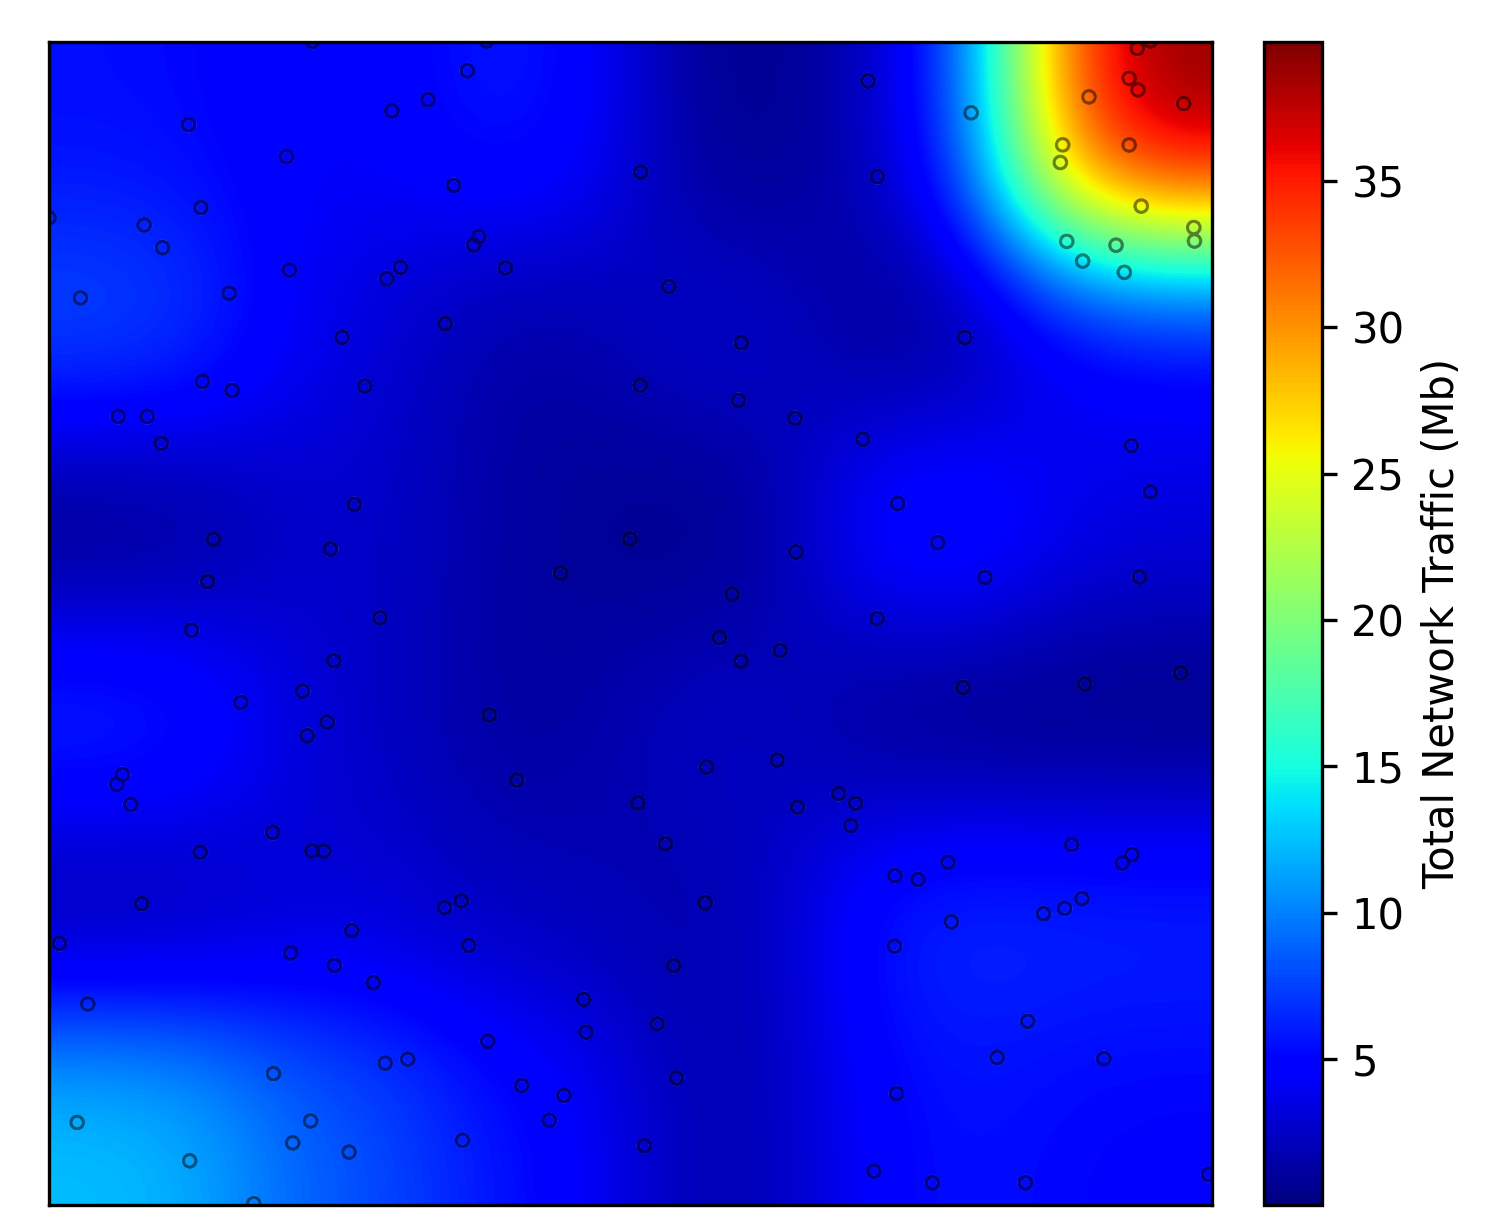

In [70]:
t = 5
n_grids2 = 6
grid_size2 = int(2*boundary/n_grids2)
marker_sz = 15 
users = users_centroid_active

val_all = np.array([user.queue_length_Mb[t-1] for user in users])
val_all += np.array([user.arrival_traffic_Mb[t] for user in users])
norm_val = 1
fname = 'dev/layered_heatmap_queueNtraffic.png'

export_layered_image(xaxis_all, yaxis_all, t, val_all, norm_val, n_grids2, grid_size2, 'Total Network Traffic (Mb)', fname)
Image(filename=fname, width=400)

Exported dev/layered_heatmap_capacity.png to d:\OneDrive\Documents\Github\DRL-for-3D-placement-of-aerial-base-stations


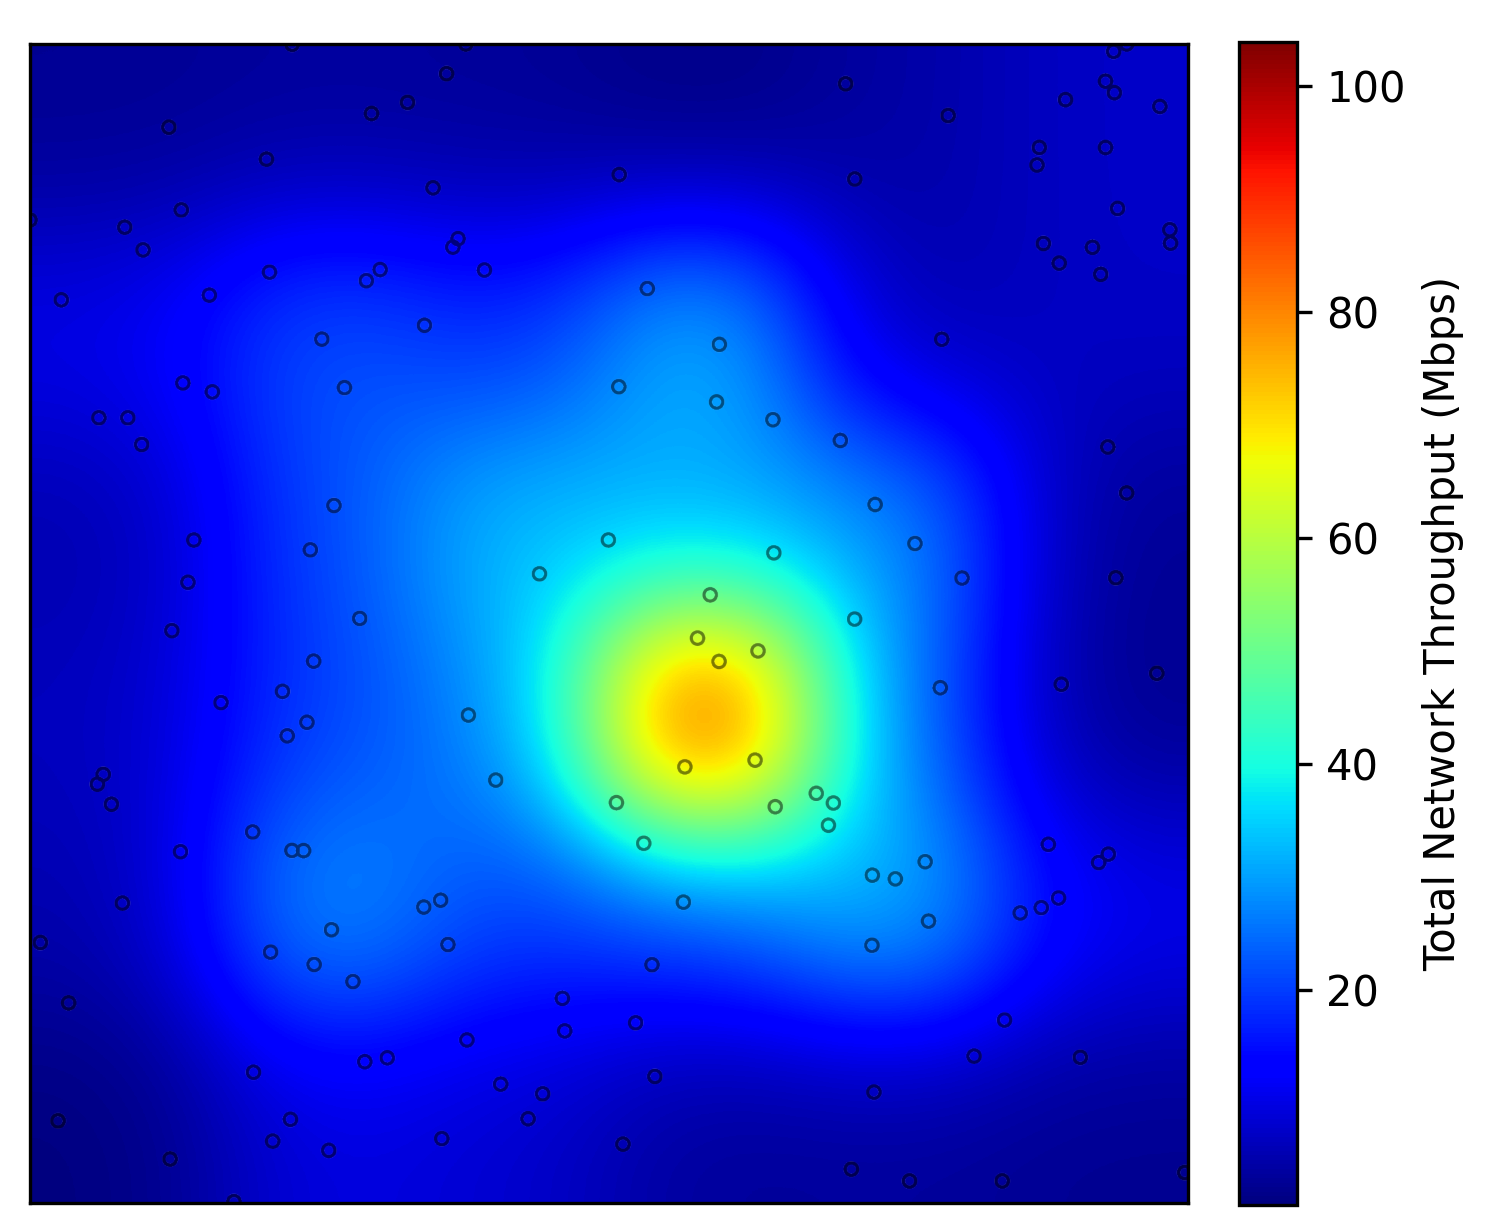

In [71]:
val_all = np.array([user.channel_capacity_Mb[t-1] for user in users])
norm_val = 1
fname = 'dev/layered_heatmap_capacity.png'

export_layered_image(xaxis_all, yaxis_all, t, val_all, norm_val, n_grids2, grid_size2, 'Total Network Throughput (Mbps)', fname)
Image(filename=fname, width=400)

Exported dev/layered_heatmap_location.png to d:\OneDrive\Documents\Github\DRL-for-3D-placement-of-aerial-base-stations


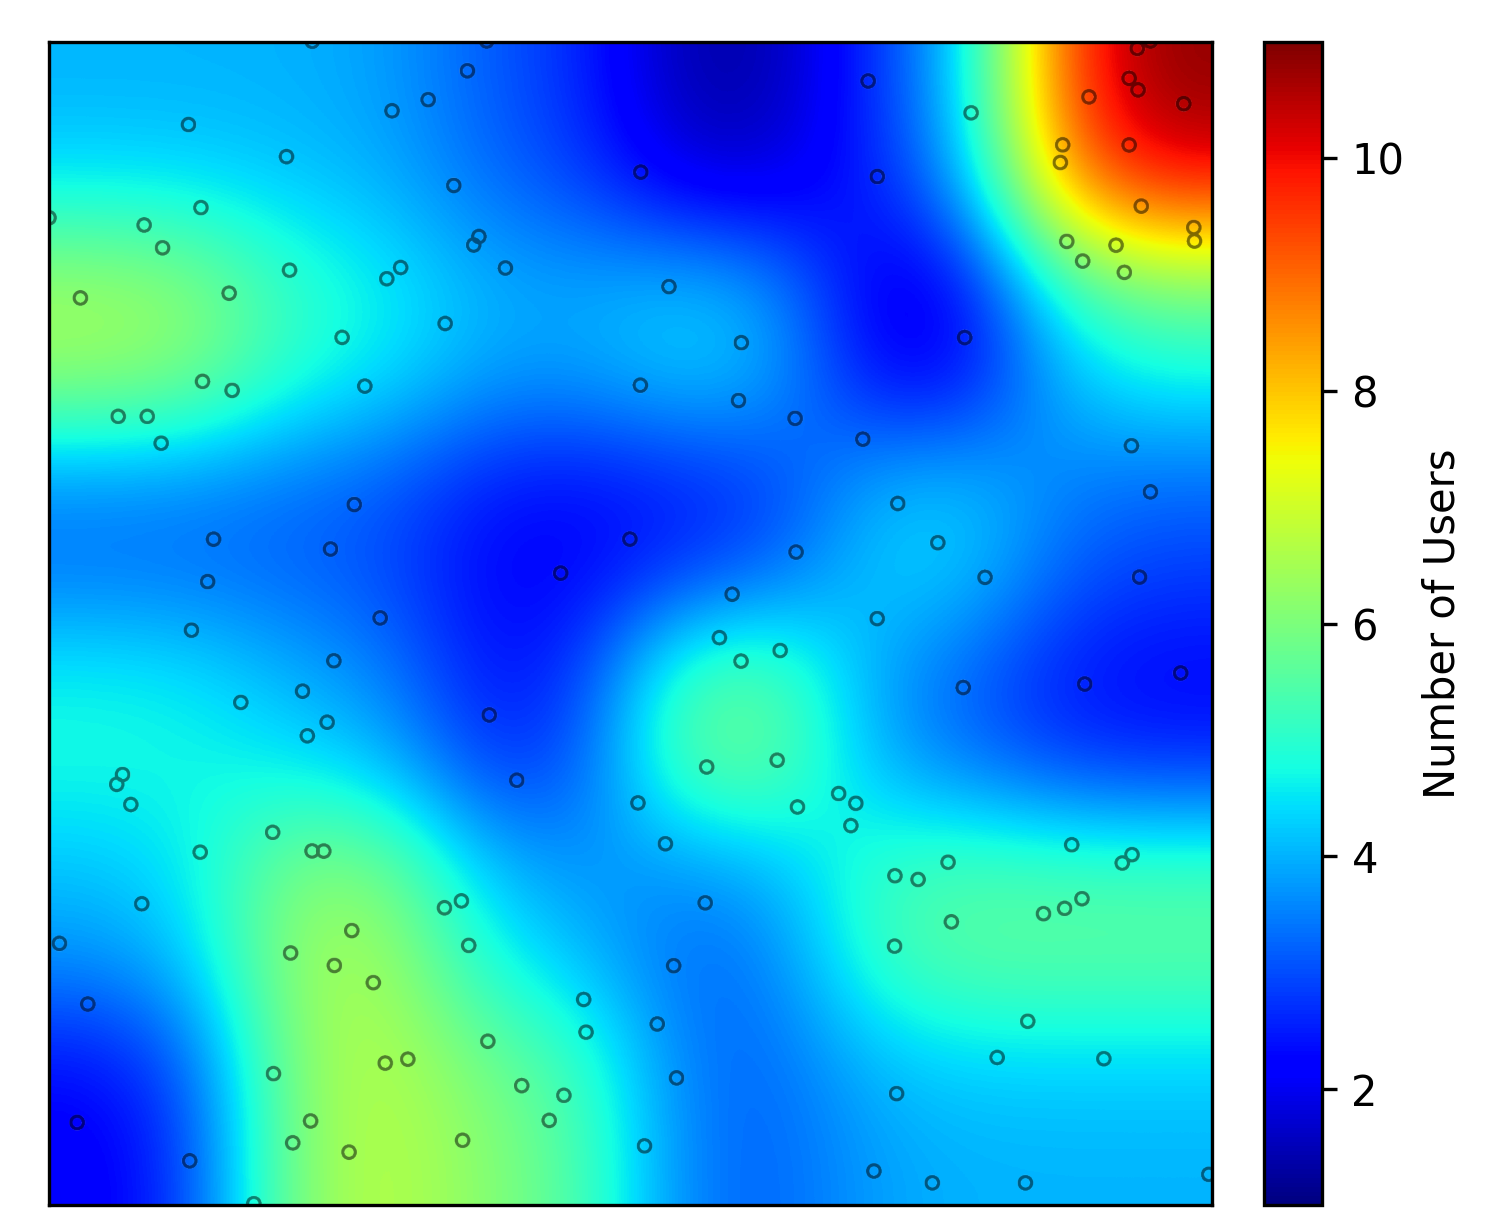

In [72]:
val_all = np.ones(n_users)
norm_val = 1
fname = 'dev/layered_heatmap_location.png'

export_layered_image(xaxis_all, yaxis_all, t, val_all, norm_val, n_grids2, grid_size2, 'Number of Users', fname)
Image(filename=fname, width=400)

### QoE Score (MOS)
NOTE: if a user is inactive, their MOS equals `np.nan` and will not be counted.

In [ ]:
rolling_interval = 1

fig, ax = plt.subplots(figsize=(6,4))   
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    mos_all = np.array([user.mos for user in users])        # shape=(n_users,n_slots)
    kpi_mmean = export_moving_average(np.nanmean(mos_all, axis=0), rolling_intv=rolling_interval)   
    ax = sns.lineplot(kpi_mmean, label=fname)

    # df = pd.DataFrame(mos_all)  
    # ax.fill_between(x = np.arange(0,n_slots), 
    #                 y1 = df.transpose().apply(np.nanmin, axis=1).values,
    #                 y2 = df.transpose().apply(np.nanmax, axis=1).values, 
    #                 alpha=0.1)
    
ax.set(xlabel='Time (s)', ylabel='QoE score (MOS)', title=f'Average QoE Score (MOS) of Active Users, Rolling interval = {rolling_interval} s',
       xlim = [0, xlim_tmax], ylim = [2.5,5], yticks = np.arange(2.5,5+.1,0.5))   
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Old KPIs

##### Number of Active Users


In [ ]:
'''Number of active users over time (for each UAV)'''
plt.figure()

for server in servers: 
    plt.plot(np.sum(server.active_state, axis=0), label=server.name)

plt.legend()
plt.grid(True)

plt.xlabel('Time slot (sec)')
plt.ylabel('Number of active users')
plt.title(f'Total # of active users over time. Total = {n_users} users')

plt.show()


##### Channel Capacity


In [ ]:
""" Average channel capacity provided by each UAV """

# plt.figure(figsize=(12,6))

# for i, server in enumerate(servers):
#     rolling_interval = 1
#     kpi = export_moving_average(np.sum(server.channel_capacity_Mb, axis=0)/n_users, rolling_intv=rolling_interval) # avoid dividing by 0
#     plt.plot(kpi, label=f'{server.name}, AVG of all users', linestyle = '-', color=colors[i])      
    
#     kpi2 = export_moving_average(np.sum(server.channel_capacity_Mb*server.active_state, axis=0)/np.maximum(1, np.sum(server.active_state, axis=0)),
#                                 rolling_intv=rolling_interval) # avoid dividing by 0
#     plt.plot(kpi2, label=f'{server.name}, AVG of ACTIVE users', linestyle = '--', color=colors[i])

# traffic_incoming_avg = np.sum(arrival_traffic_Mb, axis=0) / np.sum(traffic_state, axis=0)
# plt.plot(traffic_incoming_avg, label='AVG Arrival Traffic of ON users', color='tab:cyan')

# plt.legend(bbox_to_anchor=(1.02, 0.3), loc='lower left')
# plt.grid(True)
# plt.xlim([0, n_slots])
# plt.ylim(bottom=0)

# plt.xlabel('Time slot (sec)')
# plt.ylabel('Average channel capacity of users (Mbps)')
# plt.title(f'Average channel capacity of users, Rolling interval = {rolling_interval} s')

# plt.show()
# # plt.savefig(f'channel capacity, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

In [ ]:
""" Total Channel Capacity """

plt.figure(figsize=(12,4))

for i, server in enumerate(servers):
    rolling_interval = 1
    kpi_mmean = export_moving_average(np.sum(server.channel_capacity_Mb, axis=0), 
                                rolling_intv=rolling_interval) 
    plt.plot(kpi_mmean, label=f'{server.name}, Total of all users', linestyle = '-', color=colors[i])      
    
    kpi2 = export_moving_average(np.sum(server.channel_capacity_Mb*server.active_state, axis=0),
                                rolling_intv=rolling_interval)
    plt.plot(kpi2, label=f'{server.name}, Total of ACTIVE users', linestyle = '--', color=colors[i])

traffic_incoming_avg = np.sum(arrival_traffic_Mb, axis=0)
plt.plot(traffic_incoming_avg, label='Total Traffic of all users', color='tab:cyan')

plt.legend(bbox_to_anchor=(1.02, 0.3), loc='lower left')
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim(bottom=0)

plt.xlabel('Time slot (sec)')
plt.ylabel('Total channel capacity (Mbps)')
plt.title(f'Total channel capacity of all users, Rolling interval = {rolling_interval} s')

plt.show()
# plt.savefig(f'channel capacity, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')



##### Downlink Throughput

In [ ]:
'''Total downlink throughtput of active users'''
plt.figure(figsize=(12,4))

for server in servers: 
    rolling_interval = 1
    
    # kpi = export_moving_average(np.sum(server.downlink_throughput_Mb*server.active_state, axis=0)/np.maximum(1,np.sum(server.active_state, axis=0)),
    #                             rolling_intv=rolling_interval)  # Average Throughput of Active Users, avoid deviding by 0  
    
    kpi_mmean = export_moving_average(np.sum(server.downlink_throughput_Mb, axis=0),
                                rolling_intv=rolling_interval)      # Total Throughput 
    
    sns.lineplot(kpi_mmean, label=server.name)            
    
# plt.plot(np.sum(arrival_traffic_Mb, axis=0) / np.sum(traffic_state, axis=0), 
#          label='AVG Arrival Traffic of ON users', color='tab:cyan')   # Average Throughput of Active Users 

# Total Arrival Traffic of All Users
sns.lineplot(np.sum(arrival_traffic_Mb, axis=0), label='Total Traffic of All Users', color='tab:cyan')    

plt.legend(bbox_to_anchor=(1.02, 0.6), loc='lower left')
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim(bottom=0)

plt.xlabel('Time slot (sec)')
plt.ylabel('Total throughput (Mbps)')
plt.title(f'Total throughput of all users, Rolling interval = {rolling_interval} s')

plt.show()
# plt.savefig(f'throughput of active users, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

##### Queue Length

In [ ]:
plt.figure(figsize=(12,4))

for server in servers: 
    rolling_interval = 1
    kpi_mmean = export_moving_average(np.sum(server.queue_length_Mb, axis=0)/np.sum(server.active_state, axis=0),
                                rolling_intv=rolling_interval)          # Average Queue Length 
    
    # kpi = export_moving_average(np.sum(server.queue_length_Mb, axis=0),
                                # rolling_intv=rolling_interval)        # Total Queue Length 
                                
    ax = sns.lineplot(kpi_mmean, label=server.name)

plt.legend()
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim(bottom=0)

plt.xlabel('Time slot (sec)')
plt.ylabel('Average queue length (Mb)')
plt.title(f'Average queue length of active users, Rolling interval = {rolling_interval} s')

plt.tight_layout()

plt.show()
# plt.savefig(f'queue size, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

##### QoE Score (MOS)
Note: if a user is inactive, their MOS equals `np.nan` and will not be counted.

In [ ]:
''' Plot the average MOS of users over time '''
plt.figure(figsize=(12,4))

for server in servers: 
    rolling_interval = 1
    kpi = export_moving_average(np.nanmean(server.mos, axis=0), rolling_intv=rolling_interval)   
    ax = sns.lineplot(kpi, label=server.name)

    # df = pd.DataFrame(server.mos)  
    # ax.fill_between(x = np.arange(0,n_slots), 
    #                 y1 = df.transpose().apply(np.min, axis=1).values,
    #                 y2 = df.transpose().apply(np.max, axis=1).values, 
    #                 alpha=0.5)
    

plt.legend()
plt.grid(True)
plt.xlim([0, n_slots])
plt.ylim([1,5])
plt.yticks(np.arange(0,6))

plt.xlabel('Time slot (sec)')
plt.ylabel('QoE score (MOS) of active users')
plt.title(f'Average QoE Score (MOS) of Active Users, Rolling interval = {rolling_interval} s')
plt.tight_layout()

plt.show()
# plt.savefig(f'queue size, rolling interval={rolling_interval}.png', dpi=600, bbox_inches='tight')

In [ ]:
# df = pd.DataFrame(server.mos)  
# print(df.transpose().head(5))
# x = df.transpose().apply(np.min, axis=1).values
# print(x.shape)


##### Other plots

In [ ]:
""" Plot radius distance """
# for user_idx, user in enumerate(users): 
#     radius_distance = np.sqrt(user.x**2 + user.y**2)       # shape = (n_slots,)
#     plt.plot(radius_distance, label=f'user[{user_idx}]')
# plt.grid(True)
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Radius distance (m)')
# plt.legend()
# plt.show()


""" Plot propagation distance """
# for user_idx, user in enumerate(users): 
#     propagation_distance = np.sqrt(user.x**2 + user.y**2 + uav_altitude**2)       # shape = (n_slots,)
#     plt.plot(propagation_distance, label=f'user[{user_idx}]')
# plt.grid(True)
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Communication distance (m), UAV (fixed)')
# plt.legend()
# plt.show()


"""Plot received signal strength"""
# for user_idx, user in enumerate(users): 
#     signal_strength = pTx_downlink * uav_fixed.chgains_downlink[user_idx,:]
#     plt.plot( to_dBm(signal_strength), label=f'user[{user_idx}]' )
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Signal strength (dBm)')
# plt.legend()
# plt.grid(True)
# plt.show()


""" Plot SNR (dB) """
# for user_idx, user in enumerate(users):
#     # SNR = pTx_downlink * uav_centroid.chgains_downlink[user_idx,:] / noise_pw_total
#     SNR = pTx_downlink * uav_fixed.chgains_downlink[user_idx,:] / noise_pw_total
#     plt.plot(to_dB(SNR), label=f'user[{user_idx}]')
# plt.xlabel('Time slot (sec)')
# plt.ylabel('SNR (dB)')
# plt.legend()
# plt.grid(True)
# plt.show()


""" Plot SNR (dB) for one user between two cases """
# SNR = pTx_downlink * uav_centroid.chgains_downlink[user_idx,:] / noise_pw_total
# user_idx = 0
# SNR_fixed = pTx_downlink * uav_fixed.chgains_downlink[user_idx,:] / noise_pw_total
# SNR_centroid = pTx_downlink * uav_centroid.chgains_downlink[user_idx,:] / noise_pw_total
# plt.plot(to_dB(SNR_fixed), label=f'user[{user_idx}], UAV fixed')
# plt.plot(to_dB(SNR_centroid), label=f'user[{user_idx}], UAV (centroid)')
# plt.xlabel('Time slot (sec)')
# plt.ylabel('SNR (dB)')
# plt.legend()
# plt.grid(True)
# plt.show()


""" UAV (fixed) : Channel capacity for each user """
# for user_idx, user in enumerate(users): 
#     plt.plot(uav_fixed.channel_capacity_Mb[user_idx,:], label=f'user[{user_idx}]')
# plt.xlabel('Time slot (sec)')
# plt.ylabel('Channel capacity of each users (Mb/slot), UAV (fixed)')
# plt.legend()
# plt.grid(True)
# plt.show()

### Snapshots of real-time locations

In [ ]:
t = 2612
marker_sz = 10
xy_add = 7
mdir_uav_proposed = 7       # in # of time slots 
mdir_user = 70

for t in range(0, 500, 5):
    
    '''Calcualte downlink throughput'''
    alpha = np.ones(shape=(n_users)) * 1/n_users        # equal bandwidth allocation
    qlen_prev_Mb = uav_proposed.queue_length_Mb[:,t-1] if t > 0 else 0
    arrival_Mb = uav_proposed.arrival_traffic_Mb[:,t]

    chgains_downlink = np.zeros(shape=(n_users,))
    channel_capacity_Mb = np.zeros(shape=(n_users,))
    qlen_next_Mb = np.zeros(shape=(n_users,))
    throughput_dict = {}


    for server in servers: 
        downlink_throughput_Mb = np.zeros(shape=(n_users,))
        for i, user in enumerate(users): 
            chgains_downlink[i] = cal_channel_fading_gain(user.x[t], user.y[t], server.x[t], server.y[t], server.altitude)  
            channel_capacity_Mb[i] = cal_channel_capacity_Mb(chgains_downlink[i],  alpha=alpha[i])
            qlen_next_Mb[i] = update_queue_Mb(qlen_prev_Mb=qlen_prev_Mb[i], 
                                                arrival_Mb=arrival_Mb[i],
                                                departure_Mb=channel_capacity_Mb[i])
            downlink_throughput_Mb[i] = cal_downlink_throughput_Mb(qlen_prev_Mb=qlen_prev_Mb[i], 
                                                                arrival_Mb=arrival_Mb[i],
                                                                channel_capacity_Mb=channel_capacity_Mb[i])  
        throughput_dict[server.name] = downlink_throughput_Mb 
        print(throughput_dict[server.name])


    '''Plot figures'''
    plt.figure(figsize=(5,5))    # figsize in inch 

    # Plot the boundary 
    radius = boundary  # in meter
    plt.plot(-radius, radius, 'sw', markersize=1)
    plt.plot(-radius, -radius, 'sw', markersize=1)
    plt.plot(radius, radius, 'sw', markersize=1)
    plt.plot(radius, -radius, 'sw', markersize=1)

    ### Plot users' location
    server = uav_proposed
    for uid, user in enumerate(users):
        plt.plot(user.x[t], user.y[t], linestyle='None', marker='+', color='k', markersize=marker_sz)
        plt.annotate(text=f'{server.queue_length_Mb[uid,t-1] + server.arrival_traffic_Mb[uid,t]:.1f}', 
                    xy=(user.x[t]+xy_add, user.y[t]+xy_add))
        # plt.arrow(x=user.x[t], y=user.y[t], dx=user.x[t+mdir_user]-user.x[t], dy=user.y[t+mdir_user]-user.y[t],
        #       color='k', head_width=15, head_length=15, overhang=1)
    plt.plot(user.x[t], user.y[t], linestyle='None', marker='+', color='k', markersize=marker_sz, label='mobile users')

    ### Plot the UAV located at O (fixed)
    server = uav_fixed 
    plt.plot(server.x[t], server.y[t], linestyle="None", marker='o', color='tab:blue', label=server.name, markersize=marker_sz)
    throughput_sum = np.sum(throughput_dict[server.name])
    plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+2, server.y[t]+xy_add+2), color='tab:blue')

    ### Plot the centroid of users' location 
    # plt.plot(x_centroid[t], y_centroid[t], '^b', label='centroid of all users')
    # print(x_centroid[t], y_centroid[t])

    ### Plot the UAV movement (following centroids of all users)
    server = uav_centroid
    plt.plot(server.x[t], server.y[t], linestyle='None', marker='s', color='tab:orange', label=server.name, markersize=marker_sz)
    throughput_sum = np.sum(throughput_dict[server.name])
    plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+5, server.y[t]+xy_add+5), color='tab:orange')
    # plt.arrow(x=server.x[t], y=server.y[t], dx=server.x[t+mdir_user]-server.x[t], dy=server.y[t+mdir_user]-server.y[t],
    #           color='b', head_width=15, head_length=15, overhang=1)

    ### Plot the UAV movement (proposed)
    server = uav_proposed
    plt.plot(server.x[t], server.y[t], linestyle='None', marker='^', color='tab:green', label=server.name, markersize=marker_sz)
    throughput_sum = np.sum(throughput_dict[server.name])
    plt.annotate(text=f'TP={throughput_sum:.1f}', xy=(server.x[t]+xy_add+2, server.y[t]+xy_add+2), color='tab:green')
    # plt.arrow(x=server.x[t], y=server.y[t], dx=server.x[t+mdir_uav_proposed]-server.x[t], dy=server.y[t+mdir_uav_proposed]-server.y[t],
    #           color='r', head_width=15, head_length=15, overhang=1)

    plt.xlim(-270, 270)
    plt.ylim(-270, 270)
    plt.xticks(np.arange(-250, 251, step=100))
    plt.yticks(np.arange(-250, 251, step=100))
    plt.legend(loc='upper right')       # options: 'best', 'upper left', 'upper right', 'lower left', 'lower right'
    plt.grid(True)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.savefig(os.path.join(os.getcwd(), 'png', f"problem_illustration_t{t}.png"), bbox_inches='tight', dpi=600)


In [ ]:
'''Plot channel capacity of each user'''
# for user_id in range(n_users):
#     plt.plot(uav_fixed.channel_capacity_Mb[user_id,:], label='uav1 (fixed)')
#     plt.plot(uav_centroid.channel_capacity_Mb[user_id,:], label='uav2 (centroid)')
#     plt.xlabel('Time slot (sec)')
#     plt.ylabel(f'Channel capacity for user[{user_id}] (Mb/slot)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


### User heatmaps

In [ ]:
'''Test the UAV movement controller''' 
t = 400
x_raw = np.array([user.x[t] for user in users])
y_raw = np.array([user.y[t] for user in users])
x = x_raw + boundary
y = y_raw - boundary

server = uav_proposed

queue_Mb = server.queue_length_Mb[:,t]
traffic_Mb =  server.arrival_traffic_Mb[:,t]
ch_capacity_Mb = server.channel_capacity_Mb[:,t]

print(f'x_raw: {x_raw}')
print(f'y_raw: {y_raw}')
print(f'queue_Mb: {queue_Mb}')
print(f'traffic_Mb: {traffic_Mb}')
print(f'ch_capacity_Mb: {ch_capacity_Mb}')

heatmap = uav_controller.gen_heatmap(x_locations=x, y_locations=y, val=queue_Mb, norm_val=queue_norm_Mb)
heatmaps = uav_controller.preprocess_user_statistics(user_locations=(x,y), 
                                                user_statistics=(queue_Mb, traffic_Mb, ch_capacity_Mb),
                                                normalization_coeff=normalization_coeff)
print(f'heatmaps.shape={heatmaps.shape}')

for i in range(heatmaps.shape[-1]):
    hm_loc = sns.heatmap(data=heatmaps[:,:,i], square=True, annot = False, xticklabels=True)
    plt.title(f't={t}, heatmap channel={i}')
    plt.show() 


print(heatmaps[2])

# Export data

### User traffic and movement

In [ ]:
import pandas as pd 

def to_excel(data, fname):
    df_x = pd.DataFrame(data).transpose()
    df_x.to_excel(foldername + fname)
    
foldername = 'xlsx/'
to_excel(xaxis_all, "xlocation.xlsx")
to_excel(yaxis_all, "ylocation.xlsx")
to_excel(arrival_traffic_Mb, "arrival_traffic.xlsx")
to_excel(traffic_state, "traffic_state.xlsx")

### DNN model summary

In [ ]:
uav_controller.model.summary()

from keras.utils.vis_utils import plot_model
plot_model(uav_controller.model, to_file='dev/dnn_model.png', 
           show_shapes=True, 
           show_layer_names=False, 
           rankdir = 'TB',      # 'TB' creates a vertical plot; 'LR' creates a horizontal plot.
           expand_nested = False,
           dpi=600)

Export KPI data to xlsx files

In [ ]:
import pandas as pd 

queue_dict = {}
throughput_dict = {}
throughput_avg_alltime_dict = {}

for server in servers:
    queue_dict[server.name] = np.mean(server.queue_length_Mb, axis=0)
    throughput_dict[server.name] = np.sum(server.downlink_throughput_Mb, axis=0)/np.maximum(1, np.sum(server.active_state, axis=0))  # avoid devided by 0
    throughput_avg_alltime_dict[server.name] = np.array([np.sum(server.downlink_throughput_Mb)/np.sum(server.active_state)])

kpis = {'queue_Mb': queue_dict,                             # queue length over time 
        'throughput_Mb': throughput_dict,                   # average throughput of active users over time 
        'throughput_avg_alltime_Mb': throughput_avg_alltime_dict,       # average throughput of all time 
        'train_loss': uav_controller.train_loss_history,     
        'validation_loss': uav_controller.val_loss_history  
        }

for kpi_name, kpi_dict in kpis.items(): 
    filename_xlsx = f'{kpi_name}.xlsx'
    dataframe_lambda = pd.DataFrame(kpi_dict) 
    dataframe_lambda.to_excel( os.path.join( os.getcwd(), 'xlsx', filename_xlsx ) )
print('Exported KPI data to Excel files')
print('Path="{path}"'.format(path={os.path.join(os.getcwd(), 'xlsx')}))


Export class objects to pickle files

In [ ]:
import pickle  

folder_path = os.path.join( os.getcwd(), 'pickle' )

for server in servers: 
    filename = f'{server.name}.pickle'
    save_data(server, filepath=os.path.join(folder_path, filename))
print('Exported all uav objects to pickle files')

for user in users:
    filename = f'{user.name}.pickle'
    save_data(user, filepath=os.path.join(folder_path, filename))
print('Exported all user objects to pickle files')


Load class objects from pickle files

In [ ]:
from utils import * 

server_loaded = []
users_loaded = []

server_names = ['uav (fixed at O)', 'uav (centroid of all users)', 'uav (proposed)']
user_names = ['user[0]', 'user[1]', 'user[2]', 'user[3]', 'user[4]']

folder_path = os.path.join( os.getcwd(), 'pickle' )
for fname in server_names: 
    filename = f'{fname}.pickle'
    server_loaded.append(load_data(os.path.join(folder_path, filename)))
    
for fname in user_names:
    filename = f'{fname}.pickle'
    users_loaded.append(load_data(os.path.join(folder_path, filename)))
print('Loaded user and user objects from pickle files')


In [ ]:
for server in server_loaded:
    print(server.name)
for user in users_loaded: 
    print(user.name)